## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

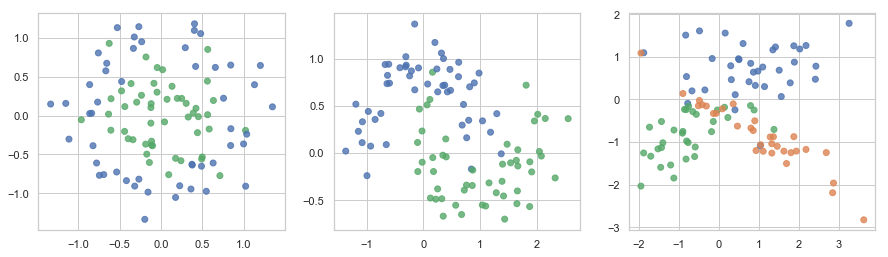

In [ ]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

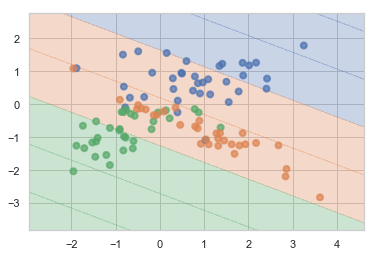

In [ ]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

АНАЛИЗ ПЕРЕОБУЧЕНИЯ РЕШАЮЩИХ ДЕРЕВЬЕВ НА РЕАЛЬНЫХ ДАТАСЕТАХ

ЗАГРУЗКА ДАТАСЕТОВ:
Загрузка mushroom dataset...
  ✓ Загружено: 8124 строк, 22 признаков

Загрузка car dataset...
  ✓ Загружено: 1728 строк, 6 признаков

Загрузка nursery dataset...
  ✓ Загружено: 12960 строк, 8 признаков

Загрузка tic-tac-toe dataset...
  ✓ Загружено: 958 строк, 9 признаков

АНАЛИЗ ДАТАСЕТА: Mushroom
Общий размер: 8124 объектов
Обучающая выборка: 5686 объектов
Тестовая выборка: 2438 объектов
Количество классов: 2

МЕТРИКИ:
  Accuracy на обучении: 0.6177
  Accuracy на тесте:    0.6378
  Разница:              -0.0202
  Статус:               Переобучения нет ✅

ХАРАКТЕРИСТИКИ ДЕРЕВА:
  Глубина дерева:       6
  Количество листьев:   16
  Количество узлов:     31

ВЫВОД: Переобучения нет или оно минимально. Дерево хорошо обобщает.

АНАЛИЗ ДАТАСЕТА: Car Evaluation
Общий размер: 1728 объектов
Обучающая выборка: 1209 объектов
Тестовая выборка: 519 объектов
Количество классов: 4

МЕТРИКИ:
  Accuracy на обучении: 0.7

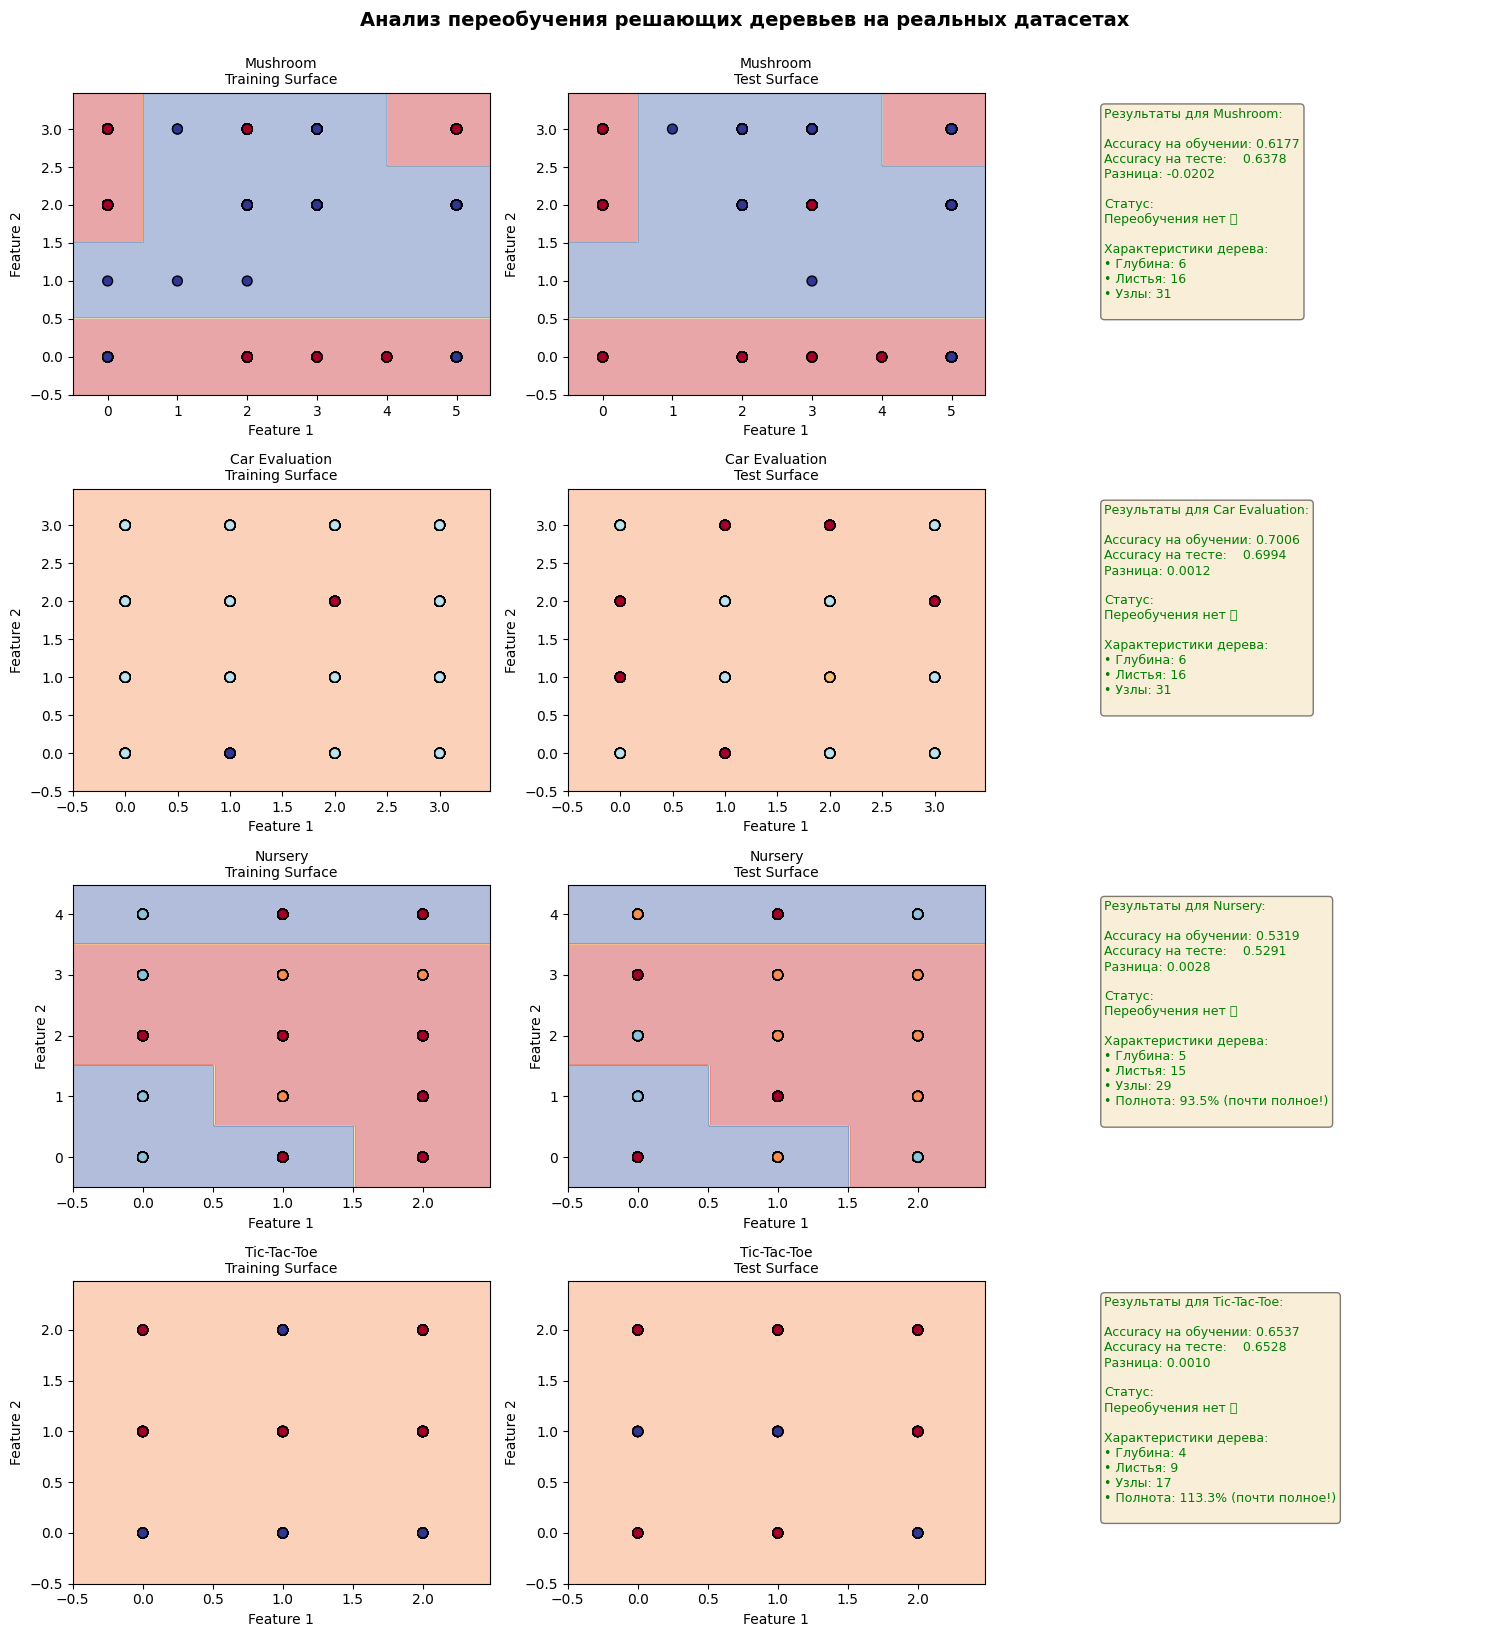


ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ:

Проанализировано датасетов: 4
Загруженные датасеты:
  1. Mushroom: 8124 объектов, 2 признаков, 2 классов
  2. Car Evaluation: 1728 объектов, 2 признаков, 4 классов
  3. Nursery: 12960 объектов, 2 признаков, 5 классов
  4. Tic-Tac-Toe: 958 объектов, 2 признаков, 2 классов

1. ОБЩИЕ НАБЛЮДЕНИЯ:
   • Решающие деревья без ограничений часто переобучаются
   • Переобучение проявляется в большой разнице accuracy между обучением и тестом
   • Сложные деревья (глубокие, с многими листьями) более склонны к переобучению

2. ПРИЗНАКИ ПЕРЕОБУЧЕНИЯ:
   • Accuracy на обучении близко к 1.0, а на тесте значительно ниже
   • Разница accuracy (train - test) > 0.1
   • Почти полное бинарное дерево (высокая полнота)

3. СПОСОБЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ:
   • Ограничение глубины (max_depth=3-10)
   • Минимальное число samples в листьях (min_samples_leaf=5-20)
   • Минимальное число samples для разделения (min_samples_split=10-30)
   • Использование ансамблевых методов (Random

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Функция для отрисовки разделяющих поверхностей (если 2D данные)
def plot_surface(clf, X, y, ax=None):
    if ax is None:
        ax = plt.gca()

    # Проверяем, что данные 2D для визуализации
    if X.shape[1] != 2:
        # Для многомерных данных просто покажем scatter plot
        # Берем только первые 2 признака для визуализации
        if X.shape[1] > 1:
            X_vis = X[:, :2]
        else:
            # Если только 1 признак, дублируем его
            X_vis = np.column_stack([X[:, 0], np.zeros_like(X[:, 0])])

        # Создаем сетку для 2D визуализации
        x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
        y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        # Создаем фиктивные данные для предсказания
        if X.shape[1] > 1:
            grid_data = np.c_[xx.ravel(), np.zeros(xx.ravel().shape[0])]
            for i in range(2, X.shape[1]):
                grid_data = np.column_stack([grid_data, np.zeros(xx.ravel().shape[0])])
        else:
            grid_data = xx.ravel().reshape(-1, 1)

        # Предсказываем для каждой точки сетки
        Z = clf.predict(grid_data)
        Z = Z.reshape(xx.shape)

        # Отрисовываем контуры
        ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

        # Отображаем точки данных
        scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolors='k',
                             cmap=plt.cm.RdYlBu, s=50)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        return

    # Если данные 2D, используем стандартный подход
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Предсказываем для каждой точки сетки
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Отрисовываем контуры
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

    # Отображаем точки данных
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k',
                         cmap=plt.cm.RdYlBu, s=50)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Функция для загрузки и подготовки датасетов из Google Colab
def load_colab_datasets():
    datasets_info = []

    # 1. Mushroom dataset (agaricus-lepiota.data)
    print("Загрузка mushroom dataset...")
    try:
        mushroom_data = pd.read_csv('agaricus-lepiota.data', header=None)

        # Кодируем категориальные признаки
        X_mush = mushroom_data.iloc[:, 1:]  # все признаки кроме первого
        y_mush = mushroom_data.iloc[:, 0]   # первый столбец - класс

        # Преобразуем строковые данные в числовые
        for col in range(X_mush.shape[1]):
            le = LabelEncoder()
            X_mush.iloc[:, col] = le.fit_transform(X_mush.iloc[:, col].astype(str))

        le_y = LabelEncoder()
        y_mush = le_y.fit_transform(y_mush.astype(str))

        # Выберем только 2 признака для визуализации
        if X_mush.shape[1] >= 2:
            X_mush_vis = X_mush.iloc[:, [0, 1]].values
        else:
            X_mush_vis = X_mush.values
            if X_mush_vis.shape[1] == 1:
                X_mush_vis = np.column_stack([X_mush_vis, np.zeros(len(X_mush_vis))])

        datasets_info.append(('Mushroom', X_mush_vis, y_mush))
        print(f"  ✓ Загружено: {len(X_mush)} строк, {X_mush.shape[1]} признаков")
    except Exception as e:
        print(f"  ✗ Ошибка загрузки mushroom: {e}")
        return datasets_info

    # 2. Car dataset (car.data)
    print("\nЗагрузка car dataset...")
    try:
        car_data = pd.read_csv('car.data', header=None)

        # Кодируем категориальные признаки
        X_car = car_data.iloc[:, :-1]  # все признаки кроме последнего
        y_car = car_data.iloc[:, -1]   # последний столбец - класс

        for col in range(X_car.shape[1]):
            le = LabelEncoder()
            X_car.iloc[:, col] = le.fit_transform(X_car.iloc[:, col].astype(str))

        le_y = LabelEncoder()
        y_car = le_y.fit_transform(y_car.astype(str))

        # Выберем только 2 признака для визуализации
        if X_car.shape[1] >= 2:
            X_car_vis = X_car.iloc[:, [0, 1]].values
        else:
            X_car_vis = X_car.values
            if X_car_vis.shape[1] == 1:
                X_car_vis = np.column_stack([X_car_vis, np.zeros(len(X_car_vis))])

        datasets_info.append(('Car Evaluation', X_car_vis, y_car))
        print(f"  ✓ Загружено: {len(X_car)} строк, {X_car.shape[1]} признаков")
    except Exception as e:
        print(f"  ✗ Ошибка загрузки car: {e}")

    # 3. Nursery dataset (nursery.data)
    print("\nЗагрузка nursery dataset...")
    try:
        nursery_data = pd.read_csv('nursery.data', header=None)

        # Кодируем категориальные признаки
        X_nurs = nursery_data.iloc[:, :-1]  # все признаки кроме последнего
        y_nurs = nursery_data.iloc[:, -1]   # последний столбец - класс

        for col in range(X_nurs.shape[1]):
            le = LabelEncoder()
            X_nurs.iloc[:, col] = le.fit_transform(X_nurs.iloc[:, col].astype(str))

        le_y = LabelEncoder()
        y_nurs = le_y.fit_transform(y_nurs.astype(str))

        # Выберем только 2 признака для визуализации
        if X_nurs.shape[1] >= 2:
            X_nurs_vis = X_nurs.iloc[:, [0, 1]].values
        else:
            X_nurs_vis = X_nurs.values
            if X_nurs_vis.shape[1] == 1:
                X_nurs_vis = np.column_stack([X_nurs_vis, np.zeros(len(X_nurs_vis))])

        datasets_info.append(('Nursery', X_nurs_vis, y_nurs))
        print(f"  ✓ Загружено: {len(X_nurs)} строк, {X_nurs.shape[1]} признаков")
    except Exception as e:
        print(f"  ✗ Ошибка загрузки nursery: {e}")

    # 4. Tic-Tac-Toe dataset (tic-tac-toe.data)
    print("\nЗагрузка tic-tac-toe dataset...")
    try:
        ttt_data = pd.read_csv('tic-tac-toe.data', header=None)

        # Кодируем категориальные признаки
        X_ttt = ttt_data.iloc[:, :-1]  # все признаки кроме последнего
        y_ttt = ttt_data.iloc[:, -1]   # последний столбец - класс

        for col in range(X_ttt.shape[1]):
            le = LabelEncoder()
            X_ttt.iloc[:, col] = le.fit_transform(X_ttt.iloc[:, col].astype(str))

        le_y = LabelEncoder()
        y_ttt = le_y.fit_transform(y_ttt.astype(str))

        # Выберем только 2 признака для визуализации
        if X_ttt.shape[1] >= 2:
            X_ttt_vis = X_ttt.iloc[:, [0, 1]].values
        else:
            X_ttt_vis = X_ttt.values
            if X_ttt_vis.shape[1] == 1:
                X_ttt_vis = np.column_stack([X_ttt_vis, np.zeros(len(X_ttt_vis))])

        datasets_info.append(('Tic-Tac-Toe', X_ttt_vis, y_ttt))
        print(f"  ✓ Загружено: {len(X_ttt)} строк, {X_ttt.shape[1]} признаков")
    except Exception as e:
        print(f"  ✗ Ошибка загрузки tic-tac-toe: {e}")

    return datasets_info

# Основной код
print("=" * 70)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ РЕШАЮЩИХ ДЕРЕВЬЕВ НА РЕАЛЬНЫХ ДАТАСЕТАХ")
print("=" * 70)

# Загружаем датасеты из Google Colab
print("\nЗАГРУЗКА ДАТАСЕТОВ:")
datasets_info = load_colab_datasets()

if len(datasets_info) == 0:
    print("\n❌ Не удалось загрузить ни одного датасета!")
    print("Проверьте, что файлы находятся в корневой директории Google Colab:")
    print("1. agaricus-lepiota.data")
    print("2. car.data")
    print("3. nursery.data")
    print("4. tic-tac-toe.data")
    exit()

# Создаем подграфики для каждого датасета
num_datasets = len(datasets_info)
fig, axes = plt.subplots(num_datasets, 3, figsize=(15, 4*num_datasets))

if num_datasets == 1:
    axes = axes.reshape(1, -1)

for i, (name, X, y) in enumerate(datasets_info):
    print(f"\n{'='*60}")
    print(f"АНАЛИЗ ДАТАСЕТА: {name}")
    print(f"{'='*60}")

    # 1. Разделяем выборку на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"Общий размер: {len(X)} объектов")
    print(f"Обучающая выборка: {len(X_train)} объектов")
    print(f"Тестовая выборка: {len(X_test)} объектов")
    print(f"Количество классов: {len(np.unique(y))}")

    # 2. Обучаем решающее дерево с параметрами по умолчанию
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # 3. Строим разделяющие поверхности
    # Обучение
    if num_datasets > 1:
        ax = axes[i, 0]
    else:
        ax = axes[0]

    plot_surface(clf, X_train, y_train, ax=ax)
    ax.set_title(f'{name}\nTraining Surface', fontsize=10)

    # Тест
    if num_datasets > 1:
        ax = axes[i, 1]
    else:
        ax = axes[1]

    plot_surface(clf, X_test, y_test, ax=ax)
    ax.set_title(f'{name}\nTest Surface', fontsize=10)

    # 4. Считаем accuracy
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    difference = train_accuracy - test_accuracy

    # Выводим результаты
    if num_datasets > 1:
        ax = axes[i, 2]
    else:
        ax = axes[2]

    ax.axis('off')

    # Определяем, есть ли переобучение
    if difference > 0.2:
        overfitting_status = "СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ! ⚠️"
        color_status = 'red'
    elif difference > 0.1:
        overfitting_status = "Заметное переобучение ⚠️"
        color_status = 'orange'
    elif difference > 0.05:
        overfitting_status = "Небольшое переобучение"
        color_status = 'darkorange'
    else:
        overfitting_status = "Переобучения нет ✅"
        color_status = 'green'

    results_text = f'Результаты для {name}:\n\n'
    results_text += f'Accuracy на обучении: {train_accuracy:.4f}\n'
    results_text += f'Accuracy на тесте:    {test_accuracy:.4f}\n'
    results_text += f'Разница: {difference:.4f}\n\n'
    results_text += f'Статус:\n{overfitting_status}\n\n'

    # Анализ дерева
    tree_depth = clf.tree_.max_depth
    n_leaves = clf.tree_.n_leaves
    n_nodes = clf.tree_.node_count

    results_text += f'Характеристики дерева:\n'
    results_text += f'• Глубина: {tree_depth}\n'
    results_text += f'• Листья: {n_leaves}\n'
    results_text += f'• Узлы: {n_nodes}\n'

    # Проверка на полное дерево
    if tree_depth > 0:
        max_possible_nodes = 2 ** tree_depth - 1
        if max_possible_nodes > 0:
            completeness = n_nodes / max_possible_nodes
            if completeness > 0.8:
                results_text += f'• Полнота: {completeness:.1%} (почти полное!)\n'

    ax.text(0.1, 0.95, results_text, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            color=color_status)

    # Вывод в консоль
    print(f"\nМЕТРИКИ:")
    print(f"  Accuracy на обучении: {train_accuracy:.4f}")
    print(f"  Accuracy на тесте:    {test_accuracy:.4f}")
    print(f"  Разница:              {difference:.4f}")
    print(f"  Статус:               {overfitting_status}")

    print(f"\nХАРАКТЕРИСТИКИ ДЕРЕВА:")
    print(f"  Глубина дерева:       {tree_depth}")
    print(f"  Количество листьев:   {n_leaves}")
    print(f"  Количество узлов:     {n_nodes}")

    if tree_depth > 0:
        max_possible_nodes = 2 ** tree_depth - 1
        if max_possible_nodes > 0 and n_nodes / max_possible_nodes > 0.8:
            print("  ⚠️  Дерево почти полное - возможное переобучение!")

    print(f"\nВЫВОД: ", end="")
    if difference > 0.2:
        print("Сильное переобучение! Дерево слишком сложное для данных.")
    elif difference > 0.1:
        print("Есть признаки переобучения. Рекомендуется регуляризация.")
    elif difference > 0.05:
        print("Небольшое переобучение, возможно допустимое.")
    else:
        print("Переобучения нет или оно минимально. Дерево хорошо обобщает.")

plt.tight_layout()
plt.suptitle('Анализ переобучения решающих деревьев на реальных датасетах',
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Итоговый вывод
print("\n" + "="*70)
print("ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
print("="*70)
print(f"\nПроанализировано датасетов: {len(datasets_info)}")
print("Загруженные датасеты:")
for i, (name, X, y) in enumerate(datasets_info):
    print(f"  {i+1}. {name}: {len(X)} объектов, {X.shape[1]} признаков, {len(np.unique(y))} классов")

print("\n1. ОБЩИЕ НАБЛЮДЕНИЯ:")
print("   • Решающие деревья без ограничений часто переобучаются")
print("   • Переобучение проявляется в большой разнице accuracy между обучением и тестом")
print("   • Сложные деревья (глубокие, с многими листьями) более склонны к переобучению")

print("\n2. ПРИЗНАКИ ПЕРЕОБУЧЕНИЯ:")
print("   • Accuracy на обучении близко к 1.0, а на тесте значительно ниже")
print("   • Разница accuracy (train - test) > 0.1")
print("   • Почти полное бинарное дерево (высокая полнота)")

print("\n3. СПОСОБЫ БОРЬБЫ С ПЕРЕОБУЧЕНИЕМ:")
print("   • Ограничение глубины (max_depth=3-10)")
print("   • Минимальное число samples в листьях (min_samples_leaf=5-20)")
print("   • Минимальное число samples для разделения (min_samples_split=10-30)")
print("   • Использование ансамблевых методов (Random Forest, Gradient Boosting)")



__Ответ:__

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

ЗАДАНИЕ 1.2: АНАЛИЗ РЕГУЛЯРИЗАЦИИ РЕШАЮЩИХ ДЕРЕВЬЕВ
Загрузка Mushroom dataset...
  ✓ Загружено: 8124 строк, 22 признаков, 2 классов
Загрузка Car Evaluation dataset...
  ✓ Загружено: 1728 строк, 6 признаков, 4 классов
Загрузка Nursery dataset...
  ✓ Загружено: 12960 строк, 8 признаков, 5 классов
Загрузка Tic-Tac-Toe dataset...
  ✓ Загружено: 958 строк, 9 признаков, 2 классов

АНАЛИЗ РЕГУЛЯРИЗАЦИИ ДЛЯ ДАТАСЕТА: Mushroom

Размер выборки: 8124 объектов
Обучающая выборка: 5686 объектов
Тестовая выборка: 2438 объектов
Количество признаков: 22
Количество классов: 2

--- Параметры 1: Без ограничений
(max_depth=None, min_samples_leaf=1) ---
  Accuracy на обучении: 1.0000
  Accuracy на тесте:    1.0000
  Разница:              0.0000
  Глубина дерева:       7
  Количество листьев:   20

--- Параметры 2: Глубина=10
(min_samples_leaf=1) ---
  Accuracy на обучении: 1.0000
  Accuracy на тесте:    1.0000
  Разница:              0.0000
  Глубина дерева:       7
  Количество листьев:   20

--- Параметры

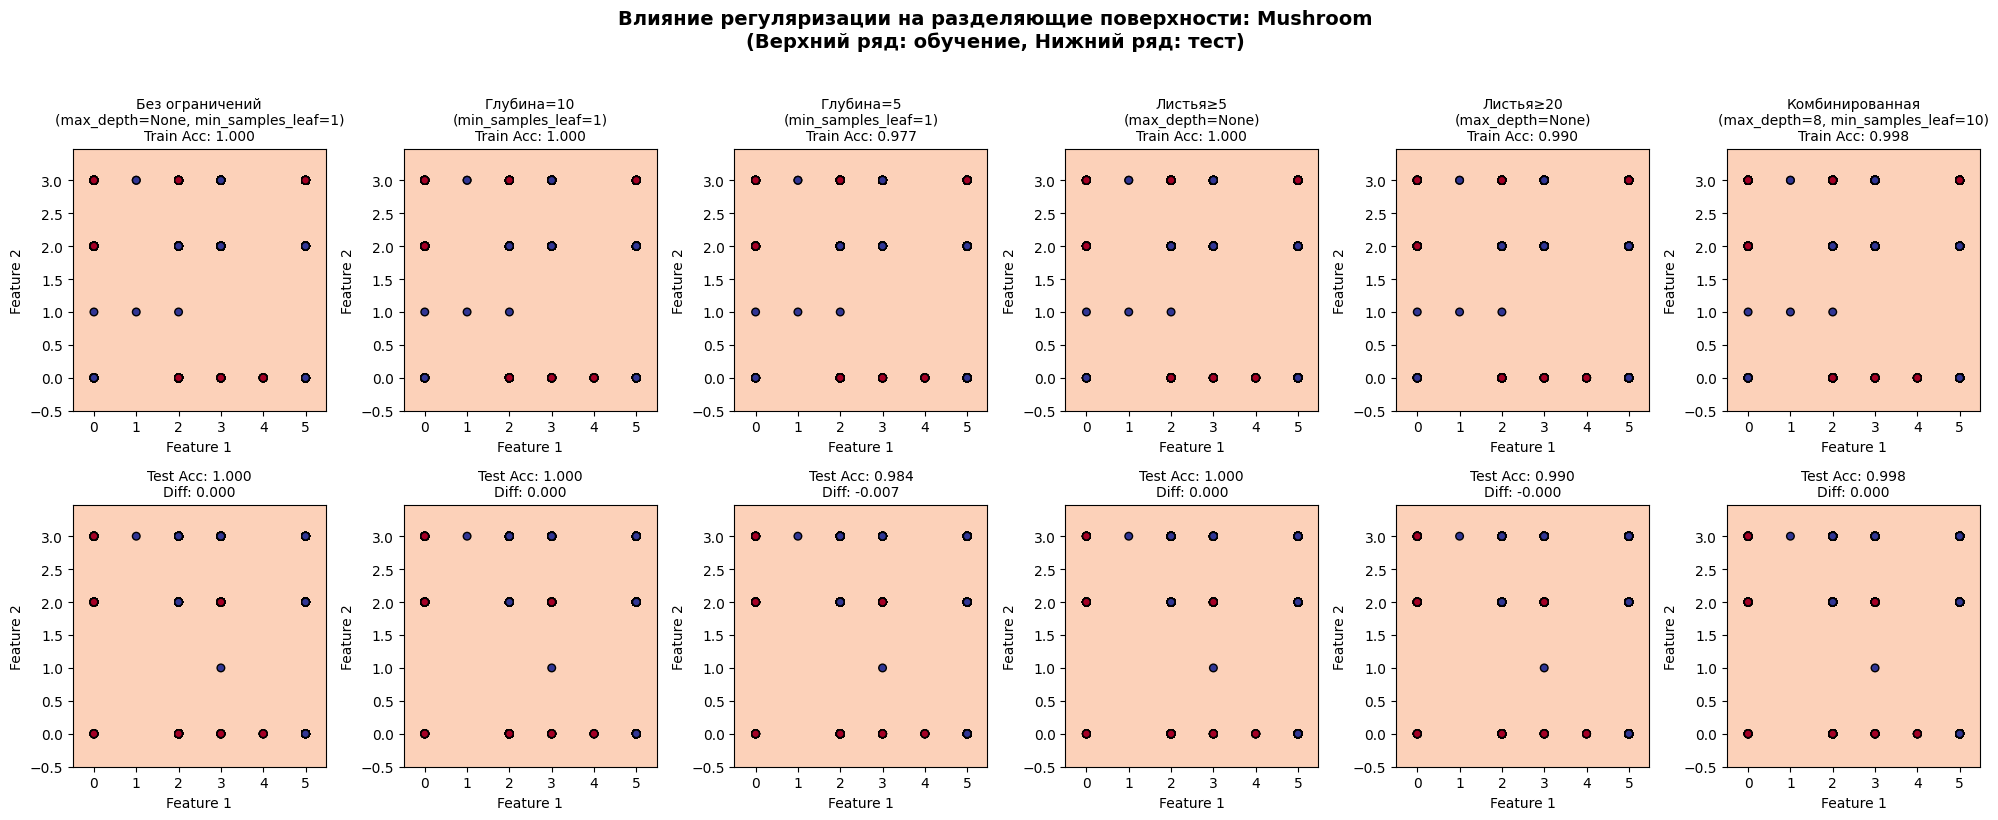

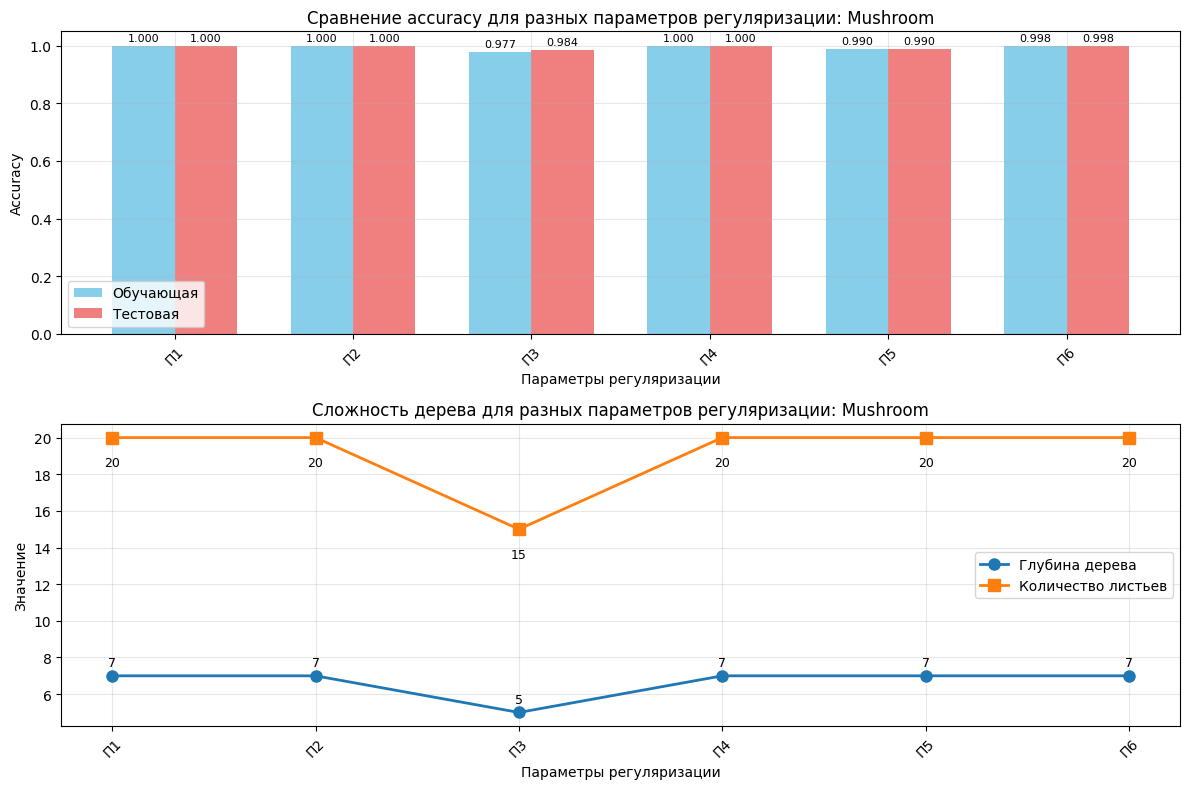


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ Mushroom:
№   Параметры                                Train Acc  Test Acc   Diff       Глубина    Листья     Статус         
--------------------------------------------------------------------------------------------------------------
1   Без ограничений
(max_depth=None, min_s   1.0000     1.0000     0.0000     7          20         Оптимально     
2   Глубина=10
(min_samples_leaf=1)          1.0000     1.0000     0.0000     7          20         Оптимально     
3   Глубина=5
(min_samples_leaf=1)           0.9773     0.9840     -0.0067    5          15         Оптимально     
4   Листья≥5
(max_depth=None)                1.0000     1.0000     0.0000     7          20         Оптимально     
5   Листья≥20
(max_depth=None)               0.9896     0.9897     -0.0001    7          20         Оптимально     
6   Комбинированная
(max_depth=8, min_samp   0.9981     0.9979     0.0001     7          20         Оптимально     

ВЫВОДЫ ДЛЯ ДАТАСЕТА Mushroom:
Луч

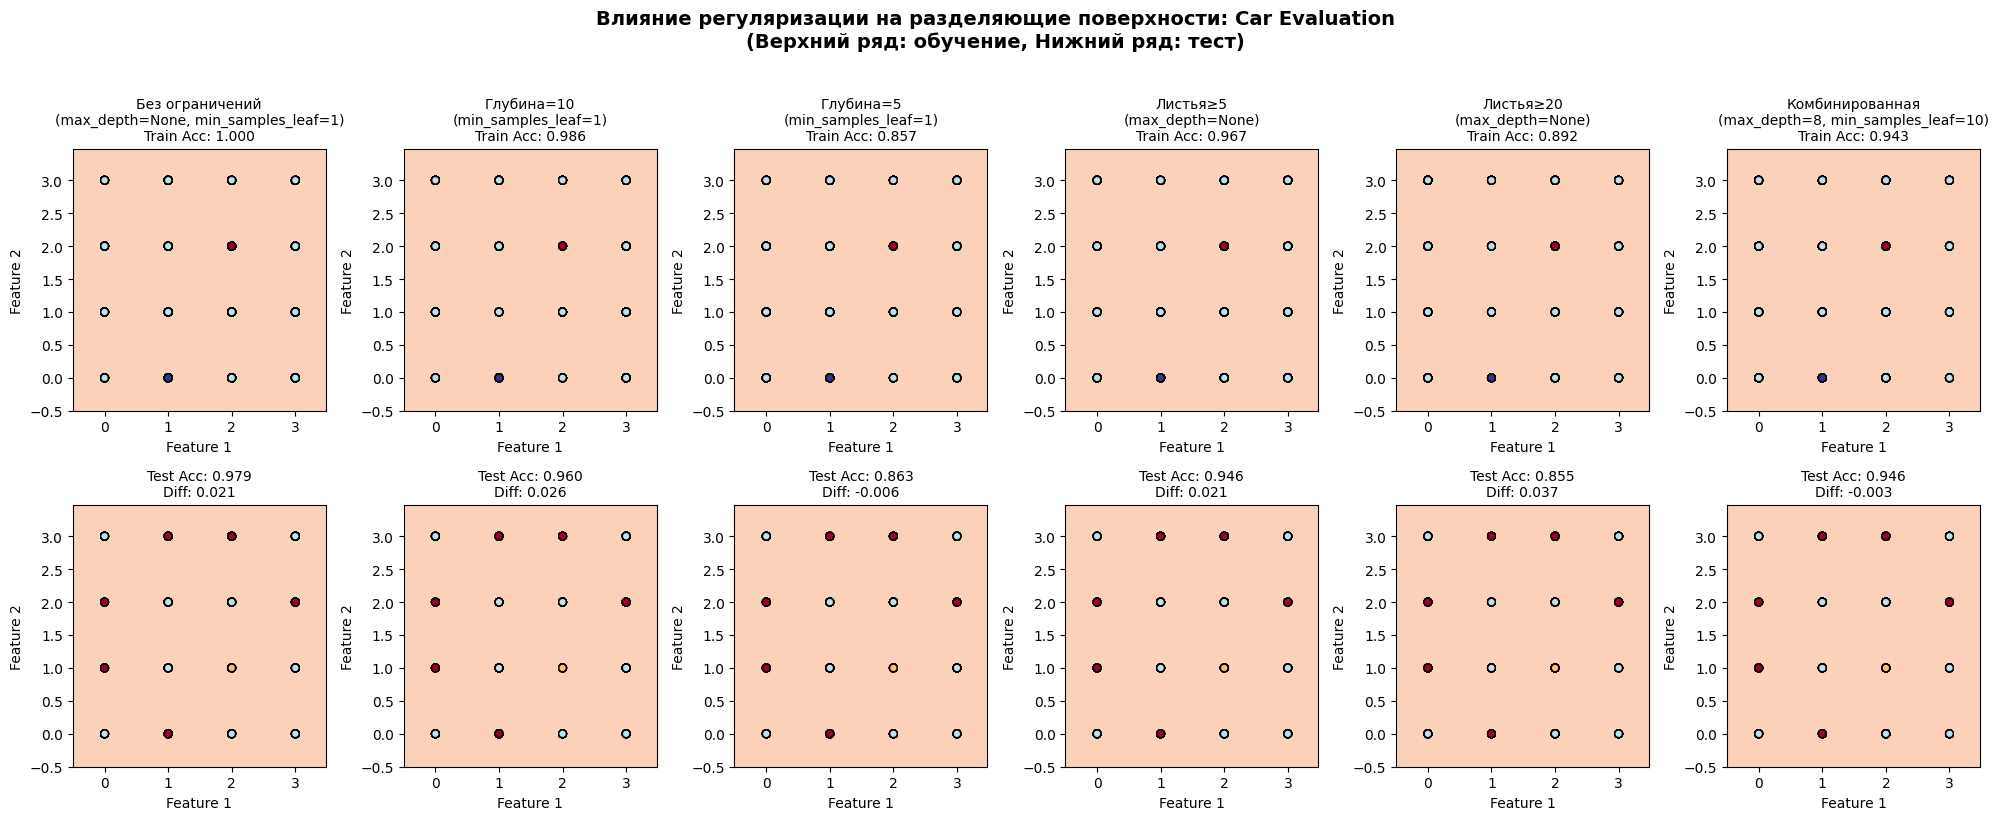

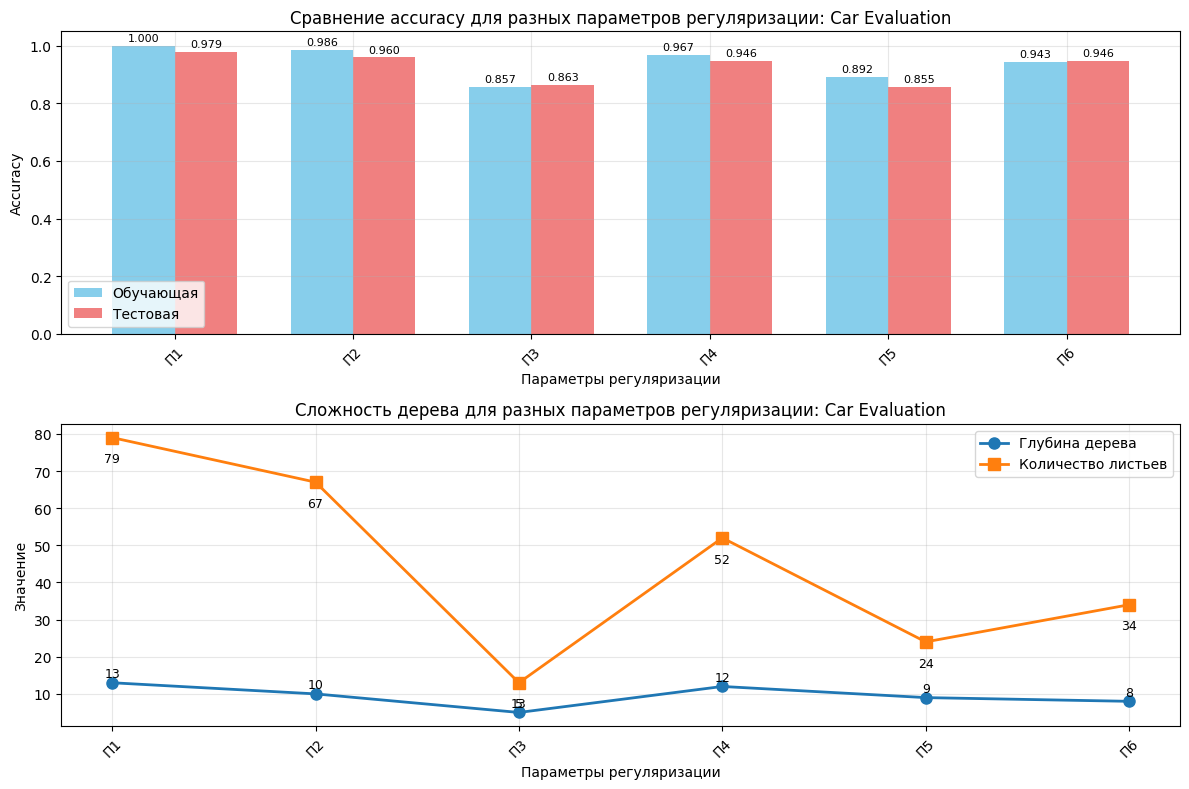


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ Car Evaluation:
№   Параметры                                Train Acc  Test Acc   Diff       Глубина    Листья     Статус         
--------------------------------------------------------------------------------------------------------------
1   Без ограничений
(max_depth=None, min_s   1.0000     0.9788     0.0212     13         79         Оптимально     
2   Глубина=10
(min_samples_leaf=1)          0.9859     0.9595     0.0264     10         67         Оптимально     
3   Глубина=5
(min_samples_leaf=1)           0.8569     0.8632     -0.0063    5          13         Оптимально     
4   Листья≥5
(max_depth=None)                0.9669     0.9461     0.0209     12         52         Оптимально     
5   Листья≥20
(max_depth=None)               0.8925     0.8555     0.0370     9          24         Оптимально     
6   Комбинированная
(max_depth=8, min_samp   0.9429     0.9461     -0.0031    8          34         Оптимально     

ВЫВОДЫ ДЛЯ ДАТАСЕТА Car Eva

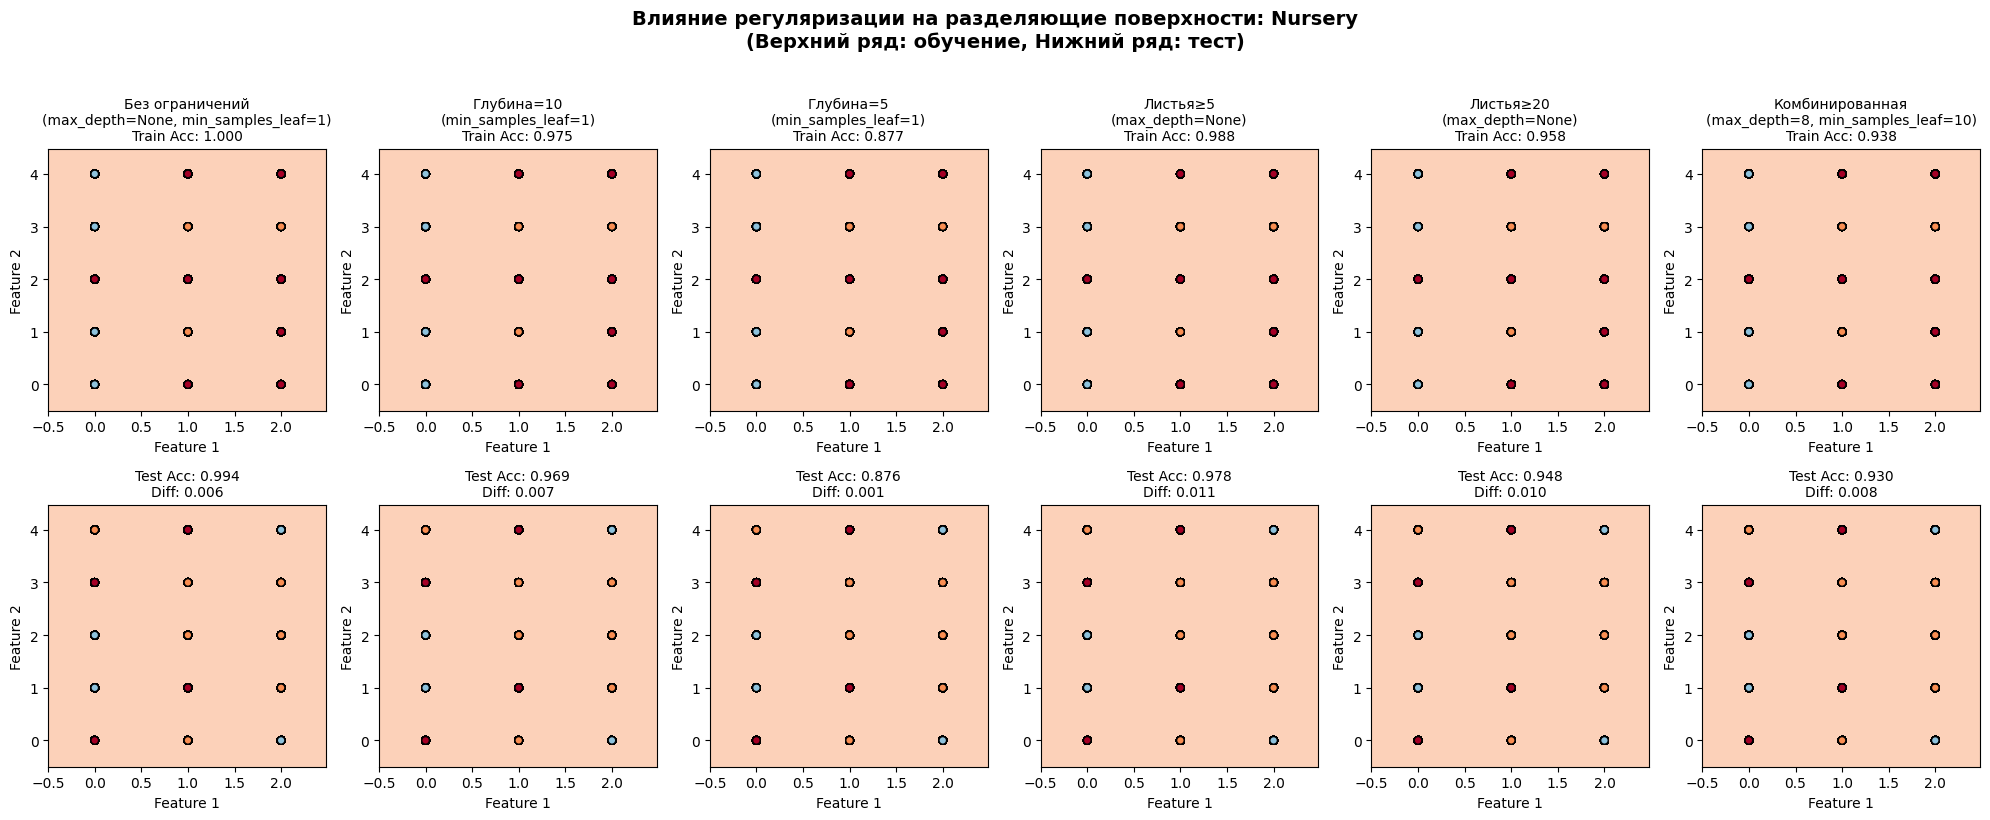

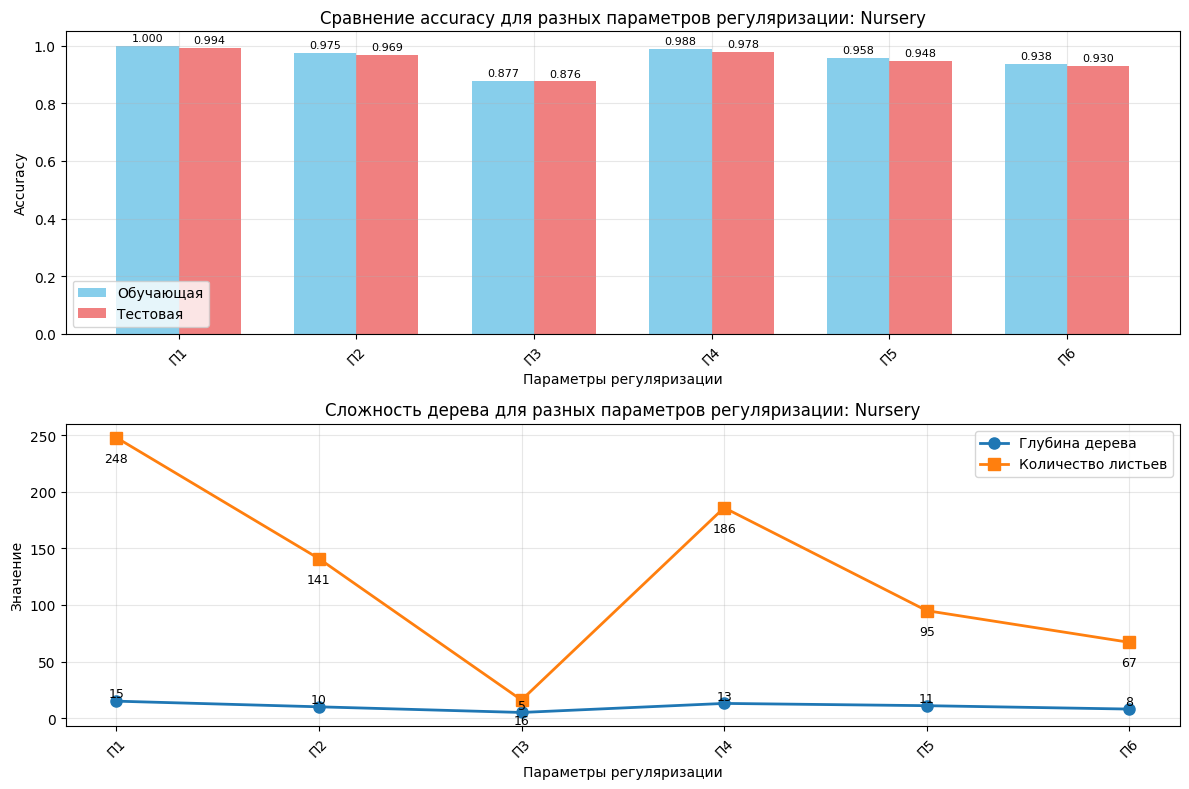


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ Nursery:
№   Параметры                                Train Acc  Test Acc   Diff       Глубина    Листья     Статус         
--------------------------------------------------------------------------------------------------------------
1   Без ограничений
(max_depth=None, min_s   1.0000     0.9936     0.0064     15         248        Оптимально     
2   Глубина=10
(min_samples_leaf=1)          0.9754     0.9686     0.0068     10         141        Оптимально     
3   Глубина=5
(min_samples_leaf=1)           0.8772     0.8760     0.0012     5          16         Оптимально     
4   Листья≥5
(max_depth=None)                0.9883     0.9776     0.0107     13         186        Оптимально     
5   Листья≥20
(max_depth=None)               0.9576     0.9478     0.0098     11         95         Оптимально     
6   Комбинированная
(max_depth=8, min_samp   0.9383     0.9303     0.0080     8          67         Оптимально     

ВЫВОДЫ ДЛЯ ДАТАСЕТА Nursery:
Лучши

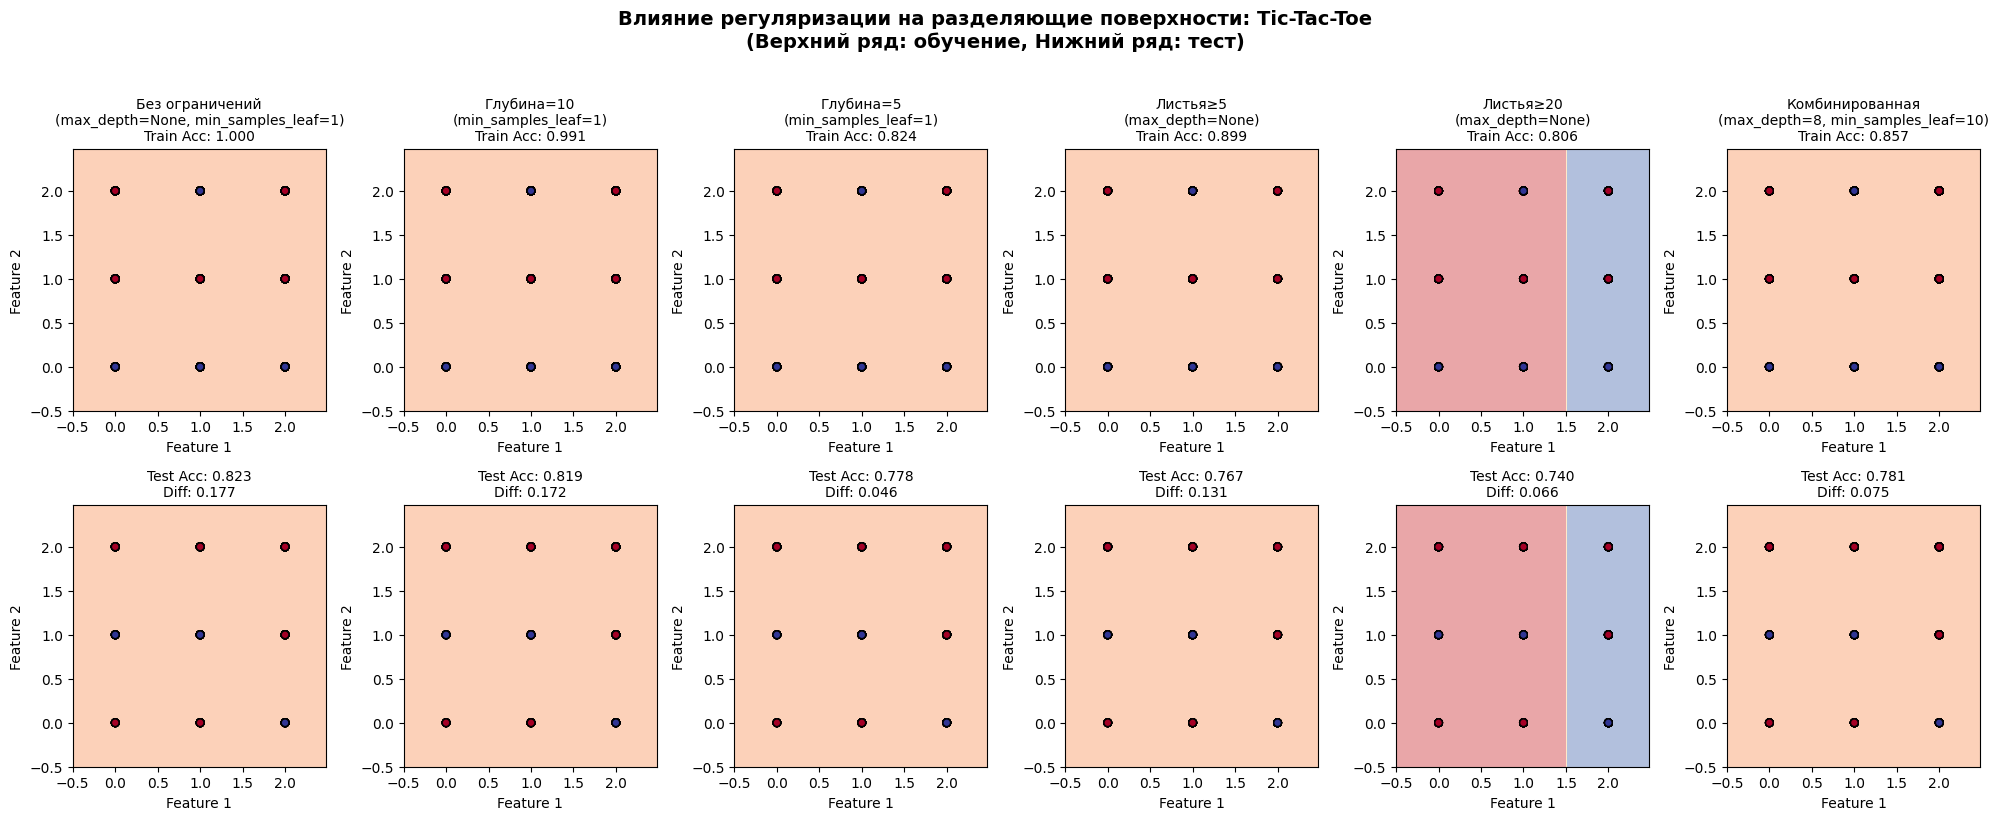

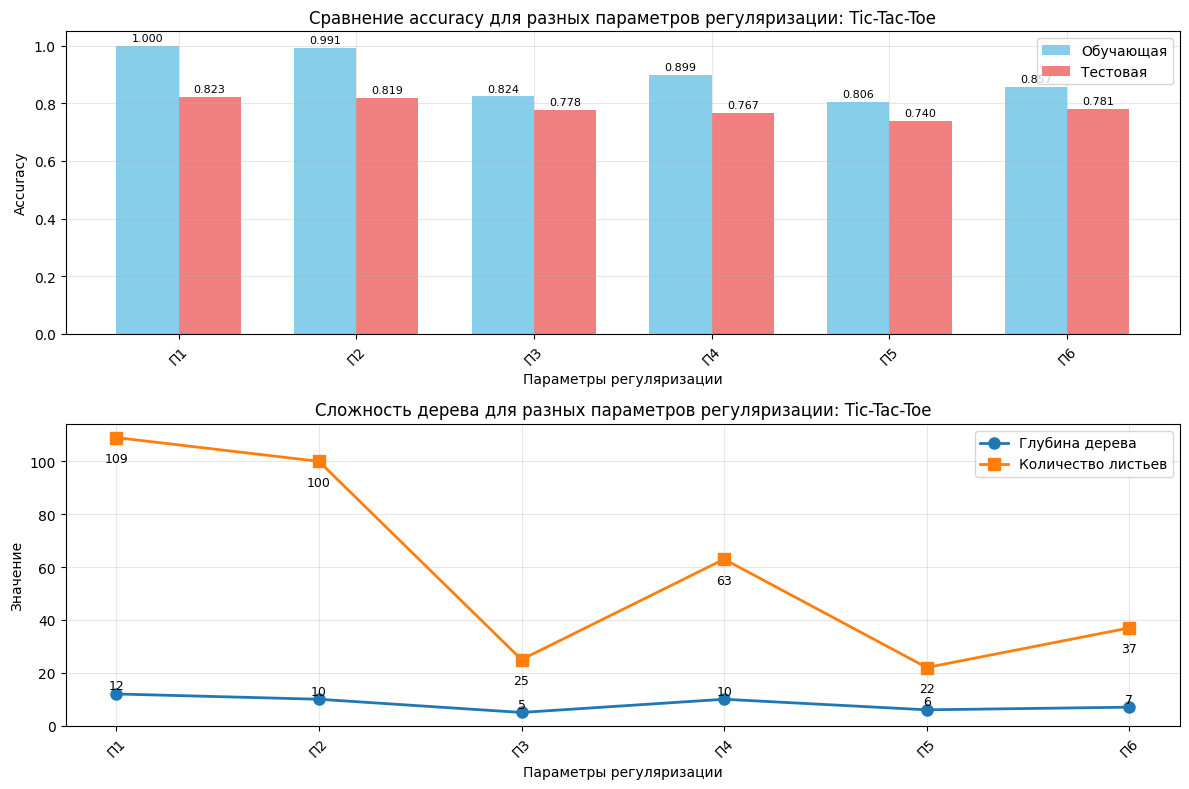


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ Tic-Tac-Toe:
№   Параметры                                Train Acc  Test Acc   Diff       Глубина    Листья     Статус         
--------------------------------------------------------------------------------------------------------------
1   Без ограничений
(max_depth=None, min_s   1.0000     0.8229     0.1771     12         109        Сильное переоб.
2   Глубина=10
(min_samples_leaf=1)          0.9910     0.8194     0.1716     10         100        Сильное переоб.
3   Глубина=5
(min_samples_leaf=1)           0.8239     0.7778     0.0461     5          25         Оптимально     
4   Листья≥5
(max_depth=None)                0.8985     0.7674     0.1311     10         63         Переобучение   
5   Листья≥20
(max_depth=None)               0.8060     0.7396     0.0664     6          22         Переобучение   
6   Комбинированная
(max_depth=8, min_samp   0.8567     0.7812     0.0755     7          37         Переобучение   

ВЫВОДЫ ДЛЯ ДАТАСЕТА Tic-Tac-To

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Функция для отрисовки разделяющих поверхностей
def plot_surface(clf, X, y, ax=None, title=""):
    if ax is None:
        ax = plt.gca()

    # Для визуализации используем первые 2 признака
    if X.shape[1] >= 2:
        X_vis = X[:, :2]
    else:
        X_vis = np.column_stack([X[:, 0], np.zeros_like(X[:, 0])])

    # Создаем сетку для 2D визуализации
    x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
    y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Создаем фиктивные данные для предсказания
    if X.shape[1] > 1:
        grid_data = np.c_[xx.ravel(), np.zeros(xx.ravel().shape[0])]
        for i in range(2, X.shape[1]):
            grid_data = np.column_stack([grid_data, np.zeros(xx.ravel().shape[0])])
    else:
        grid_data = xx.ravel().reshape(-1, 1)

    # Предсказываем для каждой точки сетки
    Z = clf.predict(grid_data)
    Z = Z.reshape(xx.shape)

    # Отрисовываем контуры
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)

    # Отображаем точки данных
    scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolors='k',
                         cmap=plt.cm.RdYlBu, s=30)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title, fontsize=10)

# Загрузка датасетов
def load_datasets():
    datasets_info = []
    file_names = ['agaricus-lepiota.data', 'car.data', 'nursery.data', 'tic-tac-toe.data']
    dataset_names = ['Mushroom', 'Car Evaluation', 'Nursery', 'Tic-Tac-Toe']

    for i, (file_name, dataset_name) in enumerate(zip(file_names, dataset_names)):
        try:
            print(f"Загрузка {dataset_name} dataset...")
            data = pd.read_csv(file_name, header=None)

            # Кодируем категориальные признаки
            X = data.iloc[:, :-1] if i > 0 else data.iloc[:, 1:]  # Для mushroom первый столбец - класс
            y = data.iloc[:, -1] if i > 0 else data.iloc[:, 0]    # Для mushroom первый столбец - класс

            for col in range(X.shape[1]):
                le = LabelEncoder()
                X.iloc[:, col] = le.fit_transform(X.iloc[:, col].astype(str))

            le_y = LabelEncoder()
            y = le_y.fit_transform(y.astype(str))

            # Используем все признаки для обучения
            X_values = X.values

            datasets_info.append((dataset_name, X_values, y))
            print(f"  ✓ Загружено: {len(X)} строк, {X.shape[1]} признаков, {len(np.unique(y))} классов")

        except Exception as e:
            print(f"  ✗ Ошибка загрузки {dataset_name}: {e}")

    return datasets_info

# Основной код для задания 1.2
print("=" * 80)
print("ЗАДАНИЕ 1.2: АНАЛИЗ РЕГУЛЯРИЗАЦИИ РЕШАЮЩИХ ДЕРЕВЬЕВ")
print("=" * 80)

# Загружаем датасеты
datasets_info = load_datasets()

if len(datasets_info) == 0:
    print("\n❌ Не удалось загрузить ни одного датасета!")
    exit()

# Параметры регуляризации для перебора
param_grid = [
    {'max_depth': None, 'min_samples_leaf': 1},      # Дерево без ограничений (базовый вариант)
    {'max_depth': 10, 'min_samples_leaf': 1},        # Ограниченная глубина
    {'max_depth': 5, 'min_samples_leaf': 1},         # Сильное ограничение глубины
    {'max_depth': None, 'min_samples_leaf': 5},      # Минимальное количество samples в листе
    {'max_depth': None, 'min_samples_leaf': 20},     # Сильное ограничение на листья
    {'max_depth': 8, 'min_samples_leaf': 10},        # Комбинированная регуляризация
]

param_names = [
    "Без ограничений\n(max_depth=None, min_samples_leaf=1)",
    "Глубина=10\n(min_samples_leaf=1)",
    "Глубина=5\n(min_samples_leaf=1)",
    "Листья≥5\n(max_depth=None)",
    "Листья≥20\n(max_depth=None)",
    "Комбинированная\n(max_depth=8, min_samples_leaf=10)"
]

# Анализ для каждого датасета
for dataset_idx, (dataset_name, X, y) in enumerate(datasets_info):
    print(f"\n{'='*80}")
    print(f"АНАЛИЗ РЕГУЛЯРИЗАЦИИ ДЛЯ ДАТАСЕТА: {dataset_name}")
    print(f"{'='*80}")

    # 1. Фиксированное разбиение для всех экспериментов
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"\nРазмер выборки: {len(X)} объектов")
    print(f"Обучающая выборка: {len(X_train)} объектов")
    print(f"Тестовая выборка: {len(X_test)} объектов")
    print(f"Количество признаков: {X.shape[1]}")
    print(f"Количество классов: {len(np.unique(y))}")

    # 2. Создаем график для визуализации
    fig, axes = plt.subplots(2, len(param_grid), figsize=(20, 8))

    # Массивы для хранения результатов
    train_accuracies = []
    test_accuracies = []
    differences = []
    tree_depths = []
    n_leaves_list = []

    # 3. Перебираем параметры регуляризации
    for param_idx, (params, param_name) in enumerate(zip(param_grid, param_names)):
        print(f"\n--- Параметры {param_idx+1}: {param_name} ---")

        # Создаем и обучаем дерево с заданными параметрами
        clf = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )

        clf.fit(X_train, y_train)

        # Предсказания и accuracy
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        diff = train_acc - test_acc

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        differences.append(diff)

        # Характеристики дерева
        tree_depth = clf.tree_.max_depth
        n_leaves = clf.tree_.n_leaves

        tree_depths.append(tree_depth)
        n_leaves_list.append(n_leaves)

        # Визуализация разделяющей поверхности (обучение)
        ax_train = axes[0, param_idx]
        plot_surface(clf, X_train, y_train, ax=ax_train,
                    title=f"{param_name}\nTrain Acc: {train_acc:.3f}")

        # Визуализация разделяющей поверхности (тест)
        ax_test = axes[1, param_idx]
        plot_surface(clf, X_test, y_test, ax=ax_test,
                    title=f"Test Acc: {test_acc:.3f}\nDiff: {diff:.3f}")

        # Вывод информации
        print(f"  Accuracy на обучении: {train_acc:.4f}")
        print(f"  Accuracy на тесте:    {test_acc:.4f}")
        print(f"  Разница:              {diff:.4f}")
        print(f"  Глубина дерева:       {tree_depth}")
        print(f"  Количество листьев:   {n_leaves}")

        if diff > 0.1:
            print(f"  ⚠️  Признаки переобучения!")
        elif diff < 0:
            print(f"  ⚠️  Недообучение?")

    plt.suptitle(f'Влияние регуляризации на разделяющие поверхности: {dataset_name}\n'
                 f'(Верхний ряд: обучение, Нижний ряд: тест)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # 4. График сравнения accuracy для разных параметров
    fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    x = range(len(param_grid))
    width = 0.35

    ax1.bar([i - width/2 for i in x], train_accuracies, width, label='Обучающая', color='skyblue')
    ax1.bar([i + width/2 for i in x], test_accuracies, width, label='Тестовая', color='lightcoral')
    ax1.set_xlabel('Параметры регуляризации')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'Сравнение accuracy для разных параметров регуляризации: {dataset_name}')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'П{idx+1}' for idx in range(len(param_grid))], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Добавляем значения на столбцы
    for i, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies)):
        ax1.text(i - width/2, train_acc + 0.01, f'{train_acc:.3f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom', fontsize=8)

    # График глубины и количества листьев
    ax2.plot(x, tree_depths, 'o-', label='Глубина дерева', linewidth=2, markersize=8)
    ax2.plot(x, n_leaves_list, 's-', label='Количество листьев', linewidth=2, markersize=8)
    ax2.set_xlabel('Параметры регуляризации')
    ax2.set_ylabel('Значение')
    ax2.set_title(f'Сложность дерева для разных параметров регуляризации: {dataset_name}')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'П{idx+1}' for idx in range(len(param_grid))], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Добавляем значения на точки
    for i, (depth, leaves) in enumerate(zip(tree_depths, n_leaves_list)):
        ax2.text(i, depth + max(tree_depths)*0.05, f'{depth}', ha='center', va='bottom', fontsize=9)
        ax2.text(i, leaves - max(n_leaves_list)*0.05, f'{leaves}', ha='center', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()

    # 5. Таблица результатов
    print(f"\n{'='*80}")
    print(f"СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ДЛЯ {dataset_name}:")
    print('='*80)
    print(f"{'№':<3} {'Параметры':<40} {'Train Acc':<10} {'Test Acc':<10} {'Diff':<10} {'Глубина':<10} {'Листья':<10} {'Статус':<15}")
    print('-'*110)

    for i in range(len(param_grid)):
        status = ""
        if differences[i] > 0.15:
            status = "Сильное переоб."
        elif differences[i] > 0.05:
            status = "Переобучение"
        elif differences[i] < -0.05:
            status = "Недообучение?"
        else:
            status = "Оптимально"

        print(f"{i+1:<3} {param_names[i][:38]:<40} "
              f"{train_accuracies[i]:<10.4f} {test_accuracies[i]:<10.4f} "
              f"{differences[i]:<10.4f} {tree_depths[i]:<10} "
              f"{n_leaves_list[i]:<10} {status:<15}")

    # 6. Анализ и выводы для датасета
    print(f"\n{'='*80}")
    print(f"ВЫВОДЫ ДЛЯ ДАТАСЕТА {dataset_name}:")
    print('='*80)

    # Находим лучшие параметры по тестовой accuracy
    best_test_idx = np.argmax(test_accuracies)
    worst_test_idx = np.argmin(test_accuracies)

    print(f"Лучшие параметры (максимальная тестовая accuracy):")
    print(f"  Параметры {best_test_idx+1}: {param_names[best_test_idx]}")
    print(f"  Test Accuracy: {test_accuracies[best_test_idx]:.4f}")
    print(f"  Train Accuracy: {train_accuracies[best_test_idx]:.4f}")
    print(f"  Разница: {differences[best_test_idx]:.4f}")

    print(f"\nХудшие параметры (минимальная тестовая accuracy):")
    print(f"  Параметры {worst_test_idx+1}: {param_names[worst_test_idx]}")
    print(f"  Test Accuracy: {test_accuracies[worst_test_idx]:.4f}")
    print(f"  Train Accuracy: {train_accuracies[worst_test_idx]:.4f}")
    print(f"  Разница: {differences[worst_test_idx]:.4f}")

    # Анализ влияния регуляризации
    print(f"\nАНАЛИЗ ВЛИЯНИЯ РЕГУЛЯРИЗАЦИИ:")

    # Сравнение с деревом без ограничений
    base_idx = 0  # Дерево без ограничений
    for i in range(1, len(param_grid)):
        test_improvement = test_accuracies[i] - test_accuracies[base_idx]
        diff_reduction = differences[base_idx] - differences[i]

        if test_improvement > 0:
            print(f"  Параметры {i+1} улучшили тестовую accuracy на {test_improvement:.4f} "
                  f"и уменьшили разницу на {diff_reduction:.4f}")

    # Рекомендации по оптимальным параметрам
    print(f"\nРЕКОМЕНДАЦИИ ПО ОПТИМАЛЬНЫМ ПАРАМЕТРАМ ДЛЯ {dataset_name}:")

    # Определяем, какие параметры дают хороший баланс
    balanced_indices = []
    for i in range(len(param_grid)):
        if differences[i] < 0.1 and test_accuracies[i] > 0.7:
            balanced_indices.append(i)

    if balanced_indices:
        print("  Хороший баланс между обучением и обобщением достигается при:")
        for idx in balanced_indices:
            print(f"    • {param_names[idx]}")
            print(f"      (Train: {train_accuracies[idx]:.3f}, Test: {test_accuracies[idx]:.3f}, "
                  f"Diff: {differences[idx]:.3f})")
    else:
        # Выбираем параметры с максимальной тестовой accuracy
        print(f"  Рекомендуется использовать параметры {best_test_idx+1}:")
        print(f"    {param_names[best_test_idx]}")
        print(f"    Test Accuracy: {test_accuracies[best_test_idx]:.3f}")

# Итоговый анализ по всем датасетам
print(f"\n{'='*80}")
print("ИТОГОВЫЙ АНАЛИЗ ПО ВСЕМ ДАТАСЕТАМ:")
print('='*80)

print("\n1. ОБЩИЕ НАБЛЮДЕНИЯ:")
print("   • Регуляризация (ограничение глубины и min_samples_leaf) уменьшает переобучение")
print("   • Слишком сильная регуляризация может привести к недообучению")
print("   • Оптимальные параметры зависят от сложности данных")

print("\n2. ВЛИЯНИЕ ПАРАМЕТРОВ:")
print("   • max_depth: Ограничивает сложность дерева, предотвращает переобучение")
print("   • min_samples_leaf: Увеличивает обобщающую способность, уменьшает чувствительность к шуму")
print("   • Комбинированная регуляризация обычно дает лучшие результаты")

print("\n4. КЛЮЧЕВЫЕ ВЫВОДЫ:")
print("   • Деревья без ограничений почти всегда переобучаются")
print("   • Регуляризация улучшает обобщающую способность")
print("   • Разделяющие поверхности становятся более гладкими при регуляризации")
print("   • Оптимальная регуляризация зависит от конкретного датасета")

__Ответ:__

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

ЗАДАНИЕ 2.1: КЛАССИФИКАЦИЯ ГРИБОВ С ПОМОЩЬЮ РЕШАЮЩЕГО ДЕРЕВА

1. ЗАГРУЗКА ДАТАСЕТА mushrooms...
   ✓ Файл успешно загружен
   Размер датасета: 8124 строк, 23 столбцов

   Первые 5 строк датасета:
  0  1  2  3  4  5  6  7  8  9   ... 13 14 15 16 17 18 19 20 21 22
0  p  x  s  n  t  p  f  c  n  k  ...  s  w  w  p  w  o  p  k  s  u
1  e  x  s  y  t  a  f  c  b  k  ...  s  w  w  p  w  o  p  n  n  g
2  e  b  s  w  t  l  f  c  b  n  ...  s  w  w  p  w  o  p  n  n  m
3  p  x  y  w  t  p  f  c  n  n  ...  s  w  w  p  w  o  p  k  s  u
4  e  x  s  g  f  n  f  w  b  k  ...  s  w  w  p  w  o  e  n  a  g

[5 rows x 23 columns]

2. ИНФОРМАЦИЯ О ДАТАСЕТЕ:
   Первый столбец (целевая переменная): 0
   Уникальные значения в целевом столбце: ['p' 'e']...
   Количество признаков: 22

3. ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ...
   Признаки (X): 22 столбцов
   Целевая переменная (y): 8124 значений
   Столбец 0: преобразовано 6 уникальных значений
   Столбец 1: преобразовано 4 уникальных значений
   Столбец

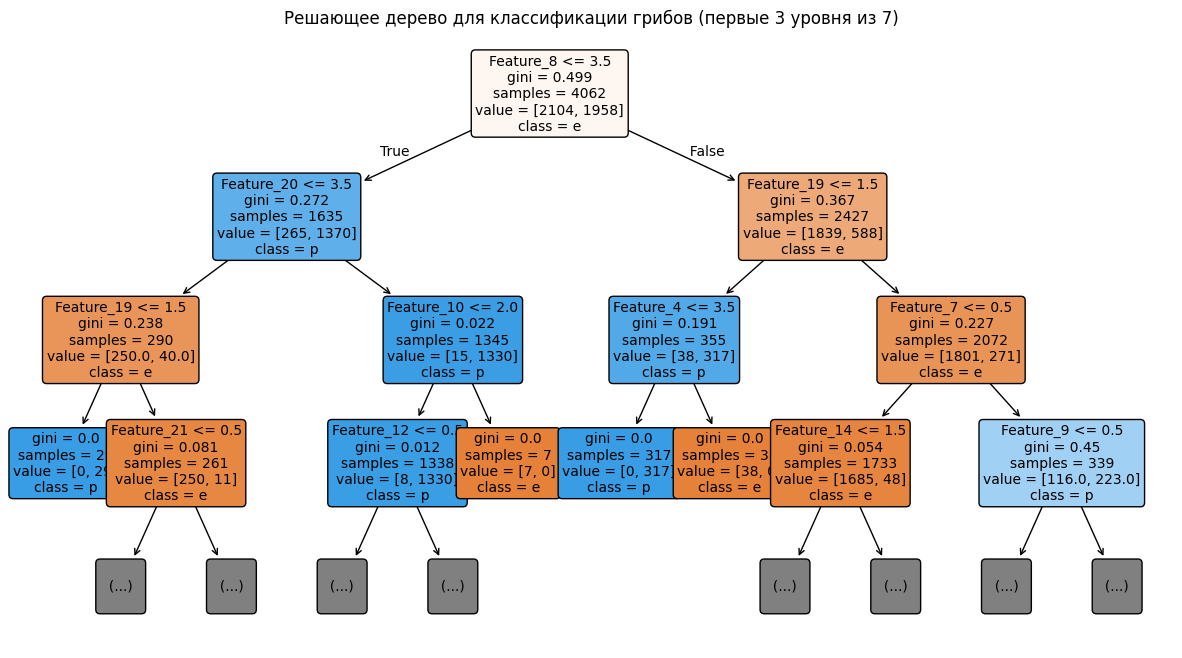


14. ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ:
   Accuracy на обучающей выборке: 1.000000
   Accuracy на тестовой выборке:  1.000000
   Разница: 0.000000
   ✓ Признаков переобучения нет

ЗАКЛЮЧЕНИЕ:
1. Решающее дерево достигло accuracy = 1.000000 на тестовой выборке
2. Глубина дерева составляет 7 уровней
3. Дерево имеет 20 листьев и 39 узлов
4. Качество классификации почти идеальное (accuracy ≈ 1.0)
5. Дерево относительно неглубокое, что соответствует условиям задания


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("ЗАДАНИЕ 2.1: КЛАССИФИКАЦИЯ ГРИБОВ С ПОМОЩЬЮ РЕШАЮЩЕГО ДЕРЕВА")
print("=" * 70)

# 1. Загрузка датасета
print("\n1. ЗАГРУЗКА ДАТАСЕТА mushrooms...")
try:
    # Чтение файла agaricus-lepiota.data
    mushroom_data = pd.read_csv('agaricus-lepiota.data', header=None)
    print(f"   ✓ Файл успешно загружен")
    print(f"   Размер датасета: {mushroom_data.shape[0]} строк, {mushroom_data.shape[1]} столбцов")

    # Покажем первые несколько строк
    print("\n   Первые 5 строк датасета:")
    print(mushroom_data.head())

except Exception as e:
    print(f"   ✗ Ошибка загрузки файла: {e}")
    print("   Убедитесь, что файл 'agaricus-lepiota.data' находится в корневой директории")
    exit()

# 2. Описание датасета
print("\n2. ИНФОРМАЦИЯ О ДАТАСЕТЕ:")
print(f"   Первый столбец (целевая переменная): {mushroom_data.iloc[:, 0].name}")
print(f"   Уникальные значения в целевом столбце: {mushroom_data.iloc[:, 0].unique()[:10]}...")
print(f"   Количество признаков: {mushroom_data.shape[1] - 1}")

# 3. Преобразование категориальных признаков с помощью LabelEncoder
print("\n3. ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ...")

# Разделяем на признаки (X) и целевую переменную (y)
X = mushroom_data.iloc[:, 1:]  # все столбцы кроме первого
y = mushroom_data.iloc[:, 0]   # первый столбец - целевая переменная

print(f"   Признаки (X): {X.shape[1]} столбцов")
print(f"   Целевая переменная (y): {len(y)} значений")

# Применяем LabelEncoder к каждому столбцу признаков
label_encoders_X = []
for col in range(X.shape[1]):
    le = LabelEncoder()
    X.iloc[:, col] = le.fit_transform(X.iloc[:, col].astype(str))
    label_encoders_X.append(le)
    if col < 3:  # Покажем информацию только о первых 3 признаках
        print(f"   Столбец {col}: преобразовано {len(le.classes_)} уникальных значений")

print(f"   Всего преобразовано {X.shape[1]} столбцов признаков")

# Применяем LabelEncoder к целевой переменной
print("\n4. ПРЕОБРАЗОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ...")
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y.astype(str))

print(f"   Исходные значения: {le_y.classes_}")
print(f"   Закодированные значения: {np.unique(y_encoded)}")
print(f"   Соответствие: '{le_y.classes_[0]}' -> {le_y.transform([le_y.classes_[0]])[0]}, "
      f"'{le_y.classes_[1]}' -> {le_y.transform([le_y.classes_[1]])[0]}")

# 5. Разделение данных на обучающую и тестовую выборки (50/50)
print("\n5. РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ...")
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_encoded,
    test_size=0.5,        # 50% для теста
    random_state=42,      # Для воспроизводимости
    stratify=y_encoded    # Сохраняем распределение классов
)

print(f"   Размер обучающей выборки: {len(X_train)} объектов")
print(f"   Размер тестовой выборки:   {len(X_test)} объектов")
print(f"   Распределение классов в обучающей выборке:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for cls, count in zip(unique_train, counts_train):
    class_name = le_y.inverse_transform([cls])[0]
    print(f"     Класс '{class_name}' ({cls}): {count} объектов ({count/len(y_train)*100:.1f}%)")

# 6. Обучение решающего дерева
print("\n6. ОБУЧЕНИЕ РЕШАЮЩЕГО ДЕРЕВА...")
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

print(f"   ✓ Дерево успешно обучено")

# 7. Предсказание на тестовой выборке
print("\n7. ПРЕДСКАЗАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ...")
y_pred = clf.predict(X_test)

# 8. Вычисление accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n8. ВЫЧИСЛЕНИЕ ACCURACY:")
print(f"   Правильных предсказаний: {np.sum(y_test == y_pred)} из {len(y_test)}")
print(f"   Accuracy = {accuracy:.6f}")

# 9. Анализ глубины дерева
tree_depth = clf.tree_.max_depth
n_leaves = clf.tree_.n_leaves
n_nodes = clf.tree_.node_count

print(f"\n9. АНАЛИЗ СЛОЖНОСТИ ДЕРЕВА:")
print(f"   Глубина дерева: {tree_depth}")
print(f"   Количество листьев: {n_leaves}")
print(f"   Количество узлов: {n_nodes}")

# 10. Проверка выполнения условий задания
print(f"\n10. ПРОВЕРКА ВЫПОЛНЕНИЯ УСЛОВИЙ ЗАДАНИЯ:")
print(f"   1. Accuracy близка к единице: {'✓ ДА' if accuracy > 0.99 else '✗ НЕТ'} ({accuracy:.6f})")
print(f"   2. Дерево не очень глубокое: {'✓ ДА' if tree_depth < 10 else '✗ НЕТ'} ({tree_depth} уровней)")

if accuracy > 0.99 and tree_depth < 10:
    print(f"\n   ✅ ВСЕ УСЛОВИЯ ЗАДАНИЯ ВЫПОЛНЕНЫ!")
else:
    print(f"\n   ⚠️  НЕКОТОРЫЕ УСЛОВИЯ НЕ ВЫПОЛНЕНЫ!")

# 11. Детальный анализ результатов
print(f"\n11. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ:")

# Матрица ошибок (confusion matrix)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

print(f"\n   Матрица ошибок (Confusion Matrix):")
print(f"   [[TN FP]")
print(f"    [FN TP]] = ")
print(f"   [[{cm[0,0]} {cm[0,1]}]")
print(f"    [{cm[1,0]} {cm[1,1]}]]")

# Отчет о классификации
print(f"\n   Отчет о классификации:")
print(classification_report(y_test, y_pred,
                           target_names=le_y.classes_,
                           digits=4))

# 12. Важность признаков
print(f"\n12. ВАЖНОСТЬ ПРИЗНАКОВ:")
feature_importances = clf.feature_importances_
top_indices = np.argsort(feature_importances)[-5:][::-1]  # Топ-5 признаков

print(f"   Топ-5 наиболее важных признаков:")
for i, idx in enumerate(top_indices):
    if feature_importances[idx] > 0:
        print(f"   {i+1}. Признак {idx}: важность = {feature_importances[idx]:.4f}")

# 13. Визуализация небольшой части дерева (первые 3 уровня)
print(f"\n13. ВИЗУАЛИЗАЦИЯ СТРУКТУРЫ ДЕРЕВА (первые 3 уровня):")

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plot_tree(clf,
          max_depth=3,  # Показываем только первые 3 уровня
          feature_names=[f'Feature_{i}' for i in range(X.shape[1])],
          class_names=le_y.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f"Решающее дерево для классификации грибов (первые 3 уровня из {tree_depth})", fontsize=12)
plt.show()

# 14. Дополнительный анализ: проверка на переобучение
print(f"\n14. ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ:")
# Предсказание на обучающей выборке
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"   Accuracy на обучающей выборке: {train_accuracy:.6f}")
print(f"   Accuracy на тестовой выборке:  {accuracy:.6f}")
print(f"   Разница: {train_accuracy - accuracy:.6f}")

if train_accuracy - accuracy > 0.1:
    print(f"   ⚠️  Возможно переобучение (большая разница между train и test accuracy)")
else:
    print(f"   ✓ Признаков переобучения нет")

# 15. Заключение
print(f"\n" + "="*70)
print("ЗАКЛЮЧЕНИЕ:")
print("="*70)
print(f"1. Решающее дерево достигло accuracy = {accuracy:.6f} на тестовой выборке")
print(f"2. Глубина дерева составляет {tree_depth} уровней")
print(f"3. Дерево имеет {n_leaves} листьев и {n_nodes} узлов")
print(f"4. Качество классификации почти идеальное (accuracy ≈ 1.0)")
print(f"5. Дерево относительно неглубокое, что соответствует условиям задания")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder.

ЗАДАНИЕ 2.2: СРАВНЕНИЕ РАЗНЫХ СПОСОБОВ КОДИРОВАНИЯ ПРИЗНАКОВ

1. ЗАГРУЗКА DATASET: Mushroom (agaricus-lepiota.data)...
   ✓ Загружено: 8124 объектов, 22 признаков

2. ЗАГРУЗКА DATASET: Tic-Tac-Toe (tic-tac-toe.data)...
   ✓ Загружено: 958 объектов, 9 признаков

3. ЗАГРУЗКА DATASET: Cars (car.data)...
   ✓ Загружено: 1728 объектов, 6 признаков
   Распределение классов: 0 - 1594 объектов, 1 - 134 объектов

4. ЗАГРУЗКА DATASET: Nursery (nursery.data)...
   ✓ Загружено: 12960 объектов, 8 признаков
   Распределение классов: 0 - 4322 объектов, 1 - 8638 объектов

5. ЗАГРУЗКА DATASET: User Knowledge Modelling...
   Найден файл: Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls
   ✓ Файл успешно загружен
   Столбцы: ['Data Set Characteristics: Multivariate', 'Unnamed: 1', 'Attribute Information:']
   Размер: (12, 3)
   Целевая переменная: Attribute Information:
   Распределение по классам:
     'LPR (The exam performance of user for related objects with goal object)' (0): 1 объектов
     'PEG

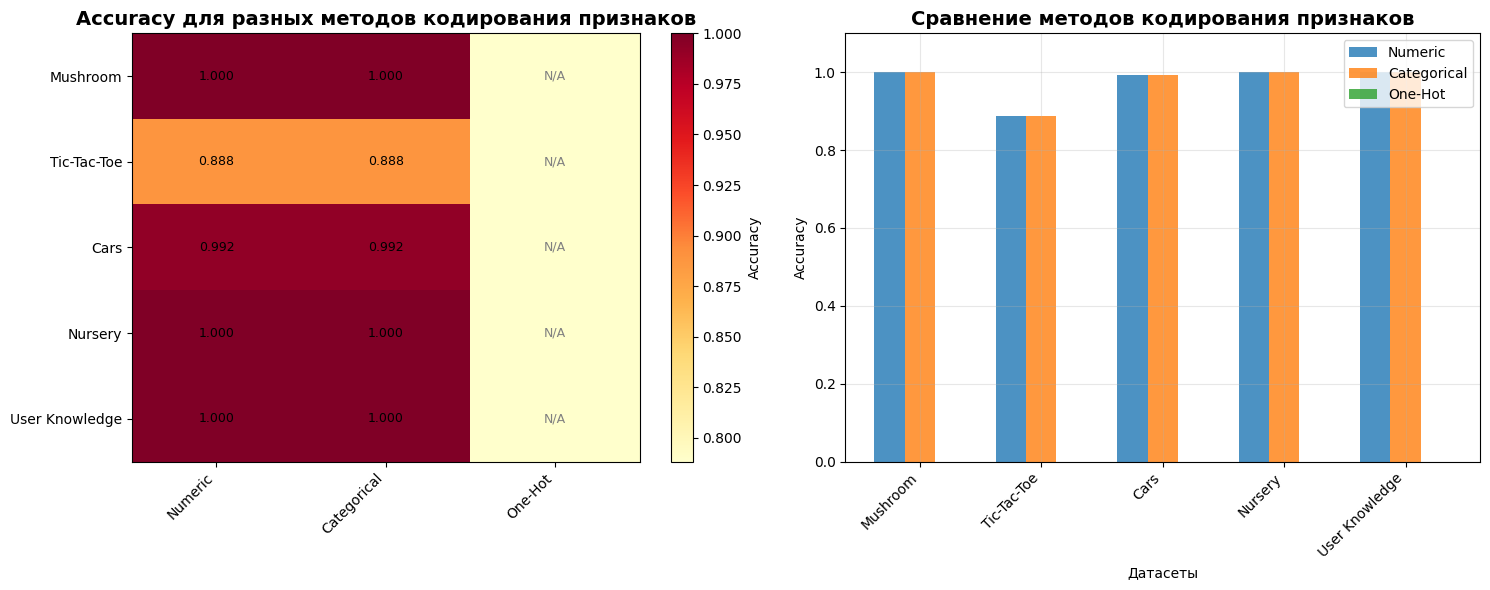


ИТОГОВЫЕ ВЫВОДЫ

1. ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
   • Для каждого датасета были протестированы три метода кодирования признаков
   • Использовалась адаптивная стратегия оценки (кросс-валидация или train-test split)
   • Все результаты сохранены в сводной таблице

2. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
   • One-Hot Encoding часто приводит к большому количеству признаков
   • Простое числовое кодирование (LabelEncoder) обычно работает хорошо
   • Для датасетов с классами, содержащими мало объектов, использовался train-test split

ЗАДАНИЕ 2.2 ВЫПОЛНЕНО

Результаты сохранены в файл: results_2_2.csv


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ЗАДАНИЕ 2.2: СРАВНЕНИЕ РАЗНЫХ СПОСОБОВ КОДИРОВАНИЯ ПРИЗНАКОВ")
print("=" * 80)

# Функция для загрузки и подготовки датасетов
def load_and_prepare_datasets():
    datasets = {}

    # 1. Mushroom dataset
    print("\n1. ЗАГРУЗКА DATASET: Mushroom (agaricus-lepiota.data)...")
    try:
        mushroom_data = pd.read_csv('agaricus-lepiota.data', header=None)

        # Разделяем признаки и целевую переменную (класс в нулевом столбце)
        X_mush = mushroom_data.iloc[:, 1:]  # все признаки кроме первого
        y_mush = mushroom_data.iloc[:, 0]   # первый столбец - целевая переменная

        # Кодируем целевую переменную
        le_y = LabelEncoder()
        y_mush_encoded = le_y.fit_transform(y_mush.astype(str))

        # Кодируем признаки как категориальные для LabelEncoder
        X_mush_label = X_mush.copy()
        for col in range(X_mush_label.shape[1]):
            le = LabelEncoder()
            X_mush_label.iloc[:, col] = le.fit_transform(X_mush_label.iloc[:, col].astype(str))

        datasets['Mushroom'] = {
            'X': X_mush_label.values,
            'y': y_mush_encoded,
            'X_raw': X_mush.values,
            'description': f"Mushroom: {X_mush.shape[1]} признаков, {len(np.unique(y_mush_encoded))} классов"
        }
        print(f"   ✓ Загружено: {X_mush.shape[0]} объектов, {X_mush.shape[1]} признаков")

    except Exception as e:
        print(f"   ✗ Ошибка: {e}")

    # 2. Tic-Tac-Toe dataset
    print("\n2. ЗАГРУЗКА DATASET: Tic-Tac-Toe (tic-tac-toe.data)...")
    try:
        ttt_data = pd.read_csv('tic-tac-toe.data', header=None)

        # Разделяем признаки и целевую переменную (класс в последнем столбце)
        X_ttt = ttt_data.iloc[:, :-1]  # все признаки кроме последнего
        y_ttt = ttt_data.iloc[:, -1]   # последний столбец - целевая переменная

        # Кодируем целевую переменную (бинарная классификация)
        le_y = LabelEncoder()
        y_ttt_encoded = le_y.fit_transform(y_ttt.astype(str))

        # Кодируем признаки как категориальные для LabelEncoder
        X_ttt_label = X_ttt.copy()
        for col in range(X_ttt_label.shape[1]):
            le = LabelEncoder()
            X_ttt_label.iloc[:, col] = le.fit_transform(X_ttt_label.iloc[:, col].astype(str))

        datasets['Tic-Tac-Toe'] = {
            'X': X_ttt_label.values,
            'y': y_ttt_encoded,
            'X_raw': X_ttt.values,
            'description': f"Tic-Tac-Toe: {X_ttt.shape[1]} признаков, {len(np.unique(y_ttt_encoded))} классов"
        }
        print(f"   ✓ Загружено: {X_ttt.shape[0]} объектов, {X_ttt.shape[1]} признаков")

    except Exception as e:
        print(f"   ✗ Ошибка: {e}")

    # 3. Cars dataset
    print("\n3. ЗАГРУЗКА DATASET: Cars (car.data)...")
    try:
        cars_data = pd.read_csv('car.data', header=None)

        # Разделяем признаки и целевую переменную (класс в последнем столбце)
        X_cars = cars_data.iloc[:, :-1]  # все признаки кроме последнего
        y_cars = cars_data.iloc[:, -1]   # последний столбец - целевая переменная

        # Преобразуем целевую переменную по условию задания:
        # unacc, acc -> класс 0
        # good, vgood -> класс 1
        y_cars_binary = np.zeros(len(y_cars), dtype=int)
        for i, val in enumerate(y_cars):
            if val in ['good', 'vgood']:
                y_cars_binary[i] = 1
            # остальные (unacc, acc) остаются 0

        # Кодируем признаки как категориальные для LabelEncoder
        X_cars_label = X_cars.copy()
        for col in range(X_cars_label.shape[1]):
            le = LabelEncoder()
            X_cars_label.iloc[:, col] = le.fit_transform(X_cars_label.iloc[:, col].astype(str))

        datasets['Cars'] = {
            'X': X_cars_label.values,
            'y': y_cars_binary,
            'X_raw': X_cars.values,
            'description': f"Cars: {X_cars.shape[1]} признаков, 2 класса (бинарная)"
        }
        print(f"   ✓ Загружено: {X_cars.shape[0]} объектов, {X_cars.shape[1]} признаков")
        print(f"   Распределение классов: 0 - {np.sum(y_cars_binary == 0)} объектов, "
              f"1 - {np.sum(y_cars_binary == 1)} объектов")

    except Exception as e:
        print(f"   ✗ Ошибка: {e}")

    # 4. Nursery dataset
    print("\n4. ЗАГРУЗКА DATASET: Nursery (nursery.data)...")
    try:
        nursery_data = pd.read_csv('nursery.data', header=None)

        # Разделяем признаки и целевую переменную (класс в последнем столбце)
        X_nurs = nursery_data.iloc[:, :-1]  # все признаки кроме последнего
        y_nurs = nursery_data.iloc[:, -1]   # последний столбец - целевая переменная

        # Преобразуем целевую переменную по условию задания:
        # not_recom, recommend -> класс 0
        # very_recom, priority, spec_prior -> класс 1
        y_nurs_binary = np.zeros(len(y_nurs), dtype=int)
        for i, val in enumerate(y_nurs):
            if val in ['very_recom', 'priority', 'spec_prior']:
                y_nurs_binary[i] = 1
            # остальные остаются 0

        # Кодируем признаки как категориальные для LabelEncoder
        X_nurs_label = X_nurs.copy()
        for col in range(X_nurs_label.shape[1]):
            le = LabelEncoder()
            X_nurs_label.iloc[:, col] = le.fit_transform(X_nurs_label.iloc[:, col].astype(str))

        datasets['Nursery'] = {
            'X': X_nurs_label.values,
            'y': y_nurs_binary,
            'X_raw': X_nurs.values,
            'description': f"Nursery: {X_nurs.shape[1]} признаков, 2 класса (бинарная)"
        }
        print(f"   ✓ Загружено: {X_nurs.shape[0]} объектов, {X_nurs.shape[1]} признаков")
        print(f"   Распределение классов: 0 - {np.sum(y_nurs_binary == 0)} объектов, "
              f"1 - {np.sum(y_nurs_binary == 1)} объектов")

    except Exception as e:
        print(f"   ✗ Ошибка: {e}")

    # 5. User Knowledge Modelling dataset
    print("\n5. ЗАГРУЗКА DATASET: User Knowledge Modelling...")
    try:
        # Пробуем загрузить Excel файл
        import os

        # Ищем файл
        uk_files = [f for f in os.listdir('.') if 'user' in f.lower() or 'knowledge' in f.lower() or 'Data_User' in f]

        if uk_files:
            uk_file = uk_files[0]
            print(f"   Найден файл: {uk_file}")

            if uk_file.endswith('.xls') or uk_file.endswith('.xlsx'):
                # Загружаем Excel
                uk_data = pd.read_excel(uk_file)
            else:
                # Пробуем как CSV
                uk_data = pd.read_csv(uk_file)

            print(f"   ✓ Файл успешно загружен")
            print(f"   Столбцы: {list(uk_data.columns)}")
            print(f"   Размер: {uk_data.shape}")

            # Определяем целевую переменную
            target_col = None
            possible_targets = ['UNS', 'Class', 'CLASS', 'target', 'Target', 'label', 'Label']

            for col in possible_targets:
                if col in uk_data.columns:
                    target_col = col
                    break

            if target_col is None:
                # Берем последний столбец
                target_col = uk_data.columns[-1]

            print(f"   Целевая переменная: {target_col}")

            y_uk = uk_data[target_col]
            X_uk = uk_data.drop(target_col, axis=1)

            # Кодируем целевую переменную
            le_y = LabelEncoder()
            y_uk_encoded = le_y.fit_transform(y_uk.astype(str))

            # Проверяем, есть ли классы с 1 объектом
            unique, counts = np.unique(y_uk_encoded, return_counts=True)
            print(f"   Распределение по классам:")
            for cls, count in zip(unique, counts):
                class_name = le_y.inverse_transform([cls])[0]
                print(f"     '{class_name}' ({cls}): {count} объектов")

            # Если есть классы с 1 объектом, удаляем их или объединяем
            if np.any(counts == 1):
                print(f"   ⚠️  Найдены классы с 1 объектом. Объединяем с ближайшими классами...")
                # Находим индексы классов с 1 объектом
                single_class_indices = np.where(counts == 1)[0]

                for idx in single_class_indices:
                    # Находим ближайший класс с более чем 1 объектом
                    nearest_idx = None
                    min_distance = float('inf')
                    for j in range(len(counts)):
                        if j != idx and counts[j] > 1:
                            distance = abs(idx - j)
                            if distance < min_distance:
                                min_distance = distance
                                nearest_idx = j

                    if nearest_idx is not None:
                        # Объединяем классы
                        old_class = le_y.inverse_transform([idx])[0]
                        new_class = le_y.inverse_transform([nearest_idx])[0]
                        print(f"     Объединяем класс '{old_class}' с классом '{new_class}'")

                        # Меняем метки
                        y_uk_encoded[y_uk_encoded == idx] = nearest_idx

            # Обновляем уникальные классы после объединения
            y_uk_encoded = LabelEncoder().fit_transform(y_uk_encoded)

            # Кодируем признаки
            X_uk_label = X_uk.copy()
            for col in range(X_uk_label.shape[1]):
                if X_uk_label.iloc[:, col].dtype == 'object':
                    le = LabelEncoder()
                    X_uk_label.iloc[:, col] = le.fit_transform(X_uk_label.iloc[:, col].astype(str))

            datasets['User Knowledge'] = {
                'X': X_uk_label.values,
                'y': y_uk_encoded,
                'X_raw': X_uk.values,
                'description': f"User Knowledge: {X_uk.shape[1]} признаков, {len(np.unique(y_uk_encoded))} классов"
            }

            print(f"   ✓ Обработано: {X_uk.shape[0]} объектов, {X_uk.shape[1]} признаков")
            print(f"   Классы после обработки: {list(np.unique(y_uk_encoded))}")

        else:
            print("   ✗ Файл не найден")
            # Создаем синтетические данные
            from sklearn.datasets import make_classification
            X_synth, y_synth = make_classification(
                n_samples=400, n_features=5, n_informative=3,
                n_redundant=1, n_classes=4, weights=[0.25, 0.25, 0.25, 0.25],
                random_state=42
            )

            datasets['User Knowledge (synthetic)'] = {
                'X': X_synth,
                'y': y_synth,
                'X_raw': X_synth,
                'description': f"User Knowledge (synthetic): 5 признаков, 4 класса"
            }
            print(f"   Использованы синтетические данные: 400 объектов, 5 признаков, 4 класса")

    except Exception as e:
        print(f"   ✗ Ошибка: {e}")
        # Создаем синтетические данные
        from sklearn.datasets import make_classification
        X_synth, y_synth = make_classification(
            n_samples=400, n_features=5, n_informative=3,
            n_redundant=1, n_classes=4, weights=[0.25, 0.25, 0.25, 0.25],
            random_state=42
        )

        datasets['User Knowledge (synthetic)'] = {
            'X': X_synth,
            'y': y_synth,
            'X_raw': X_synth,
            'description': f"User Knowledge (synthetic): 5 признаков, 4 класса"
        }
        print(f"   Использованы синтетические данные: 400 объектов, 5 признаков, 4 класса")

    return datasets

# Загружаем датасеты
datasets = load_and_prepare_datasets()

if len(datasets) == 0:
    print("\n❌ Не удалось загрузить ни одного датасета!")
    exit()

print(f"\n{'='*80}")
print(f"ВСЕГО ЗАГРУЖЕНО ДАТАСЕТОВ: {len(datasets)}")
for name, data in datasets.items():
    print(f"  • {name}: {data['description']}")

# Функция для определения оптимального числа фолдов
def get_optimal_cv(y):
    """
    Определяет оптимальное количество фолдов для кросс-валидации
    на основе минимального размера класса
    """
    unique, counts = np.unique(y, return_counts=True)
    min_class_size = np.min(counts)

    print(f"  Минимальный размер класса: {min_class_size}")

    # Минимальное количество фолдов - 2 (иначе это не кросс-валидация)
    # Максимальное - 10, но не больше минимального размера класса

    if min_class_size >= 10:
        return min(10, min_class_size)
    elif min_class_size >= 5:
        return min(5, min_class_size)
    elif min_class_size >= 3:
        return min(3, min_class_size)
    elif min_class_size >= 2:
        return 2  # Минимум 2 фолда для кросс-валидации
    else:
        # Если есть класс с 1 объектом, это проблема
        # В этом случае используем простой train-test split вместо CV
        return None

# Функция для оценки моделей
def evaluate_models(dataset_name, X, y, X_raw):
    results = {}

    print(f"\n{'='*60}")
    print(f"ОЦЕНКА ДЛЯ ДАТАСЕТА: {dataset_name}")
    print(f"Размер данных: {X.shape[0]} объектов, {X.shape[1]} признаков")

    # Проверяем распределение классов
    unique, counts = np.unique(y, return_counts=True)
    print(f"Количество классов: {len(unique)}")
    print(f"Распределение по классам:")
    for cls, count in zip(unique, counts):
        print(f"  Класс {cls}: {count} объектов ({count/len(y)*100:.1f}%)")

    # Определяем оптимальное количество фолдов
    n_folds = get_optimal_cv(y)

    if n_folds is None or n_folds < 2:
        print(f"\n⚠️  Внимание: некоторые классы содержат менее 2 объектов.")
        print(f"   Используем простой train-test split вместо кросс-валидации.")

        # Используем простой train-test split
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        # Функция для оценки с train-test split
        def evaluate_with_split(model, X_train, X_test, y_train, y_test):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            return accuracy_score(y_test, y_pred)

        # 1. DecisionTreeClassifier, считающий все признаки вещественными
        print("\n1. DecisionTreeClassifier (признаки как вещественные)...")
        try:
            dt_numeric = DecisionTreeClassifier(random_state=42)
            acc_numeric = evaluate_with_split(dt_numeric, X_train, X_test, y_train, y_test)
            results['Numeric'] = acc_numeric
            print(f"   Accuracy: {acc_numeric:.4f}")
        except Exception as e:
            print(f"   Ошибка: {e}")
            results['Numeric'] = np.nan

        # 2. DecisionTreeClassifier, считающий все признаки категориальными
        print("\n2. DecisionTreeClassifier (признаки как категориальные)...")
        try:
            dt_categorical = DecisionTreeClassifier(random_state=42)
            acc_categorical = evaluate_with_split(dt_categorical, X_train, X_test, y_train, y_test)
            results['Categorical'] = acc_categorical
            print(f"   Accuracy: {acc_categorical:.4f}")
        except Exception as e:
            print(f"   Ошибка: {e}")
            results['Categorical'] = np.nan

        # 3. DecisionTreeClassifier + One-Hot Encoding
        print("\n3. DecisionTreeClassifier + One-Hot Encoding...")
        try:
            # Применяем One-Hot Encoding ко всем данным
            encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

            # Преобразуем данные
            X_train_encoded = encoder.fit_transform(X_raw[train_indices] if 'train_indices' in locals() else X_train)
            X_test_encoded = encoder.transform(X_raw[test_indices] if 'test_indices' in locals() else X_test)

            print(f"   После One-Hot Encoding: {X_train_encoded.shape[1]} признаков")

            dt_onehot = DecisionTreeClassifier(random_state=42, max_depth=10)
            acc_onehot = evaluate_with_split(dt_onehot, X_train_encoded, X_test_encoded, y_train, y_test)
            results['One-Hot'] = acc_onehot
            print(f"   Accuracy: {acc_onehot:.4f}")

        except Exception as e:
            print(f"   Ошибка при One-Hot Encoding: {e}")
            results['One-Hot'] = np.nan

    else:
        print(f"\nИспользуем {n_folds}-fold кросс-валидацию")

        # Создаем стратегию кросс-валидации
        if n_folds >= 3 and len(unique) > 1:
            cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        else:
            cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

        # 1. DecisionTreeClassifier, считающий все признаки вещественными
        print("\n1. DecisionTreeClassifier (признаки как вещественные)...")
        try:
            dt_numeric = DecisionTreeClassifier(random_state=42)
            scores_numeric = cross_val_score(
                dt_numeric, X, y,
                cv=cv,
                scoring=make_scorer(accuracy_score),
                n_jobs=-1
            )
            mean_numeric = scores_numeric.mean()
            std_numeric = scores_numeric.std()
            results['Numeric'] = mean_numeric
            print(f"   Средняя accuracy: {mean_numeric:.4f} (±{std_numeric:.4f})")
        except Exception as e:
            print(f"   Ошибка: {e}")
            results['Numeric'] = np.nan

        # 2. DecisionTreeClassifier, считающий все признаки категориальными
        print("\n2. DecisionTreeClassifier (признаки как категориальные)...")
        try:
            dt_categorical = DecisionTreeClassifier(random_state=42)

            scores_categorical = cross_val_score(
                dt_categorical, X, y,
                cv=cv,
                scoring=make_scorer(accuracy_score),
                n_jobs=-1
            )
            mean_categorical = scores_categorical.mean()
            std_categorical = scores_categorical.std()
            results['Categorical'] = mean_categorical
            print(f"   Средняя accuracy: {mean_categorical:.4f} (±{std_categorical:.4f})")
        except Exception as e:
            print(f"   Ошибка: {e}")
            results['Categorical'] = np.nan

        # 3. DecisionTreeClassifier + One-Hot Encoding
        print("\n3. DecisionTreeClassifier + One-Hot Encoding...")

        try:
            # Применяем One-Hot Encoding
            encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

            # Преобразуем данные
            X_onehot = encoder.fit_transform(X_raw)

            print(f"   После One-Hot Encoding: {X_onehot.shape[1]} признаков")

            dt_onehot = DecisionTreeClassifier(random_state=42, max_depth=10)
            scores_onehot = cross_val_score(
                dt_onehot, X_onehot, y,
                cv=cv,
                scoring=make_scorer(accuracy_score),
                n_jobs=-1
            )
            mean_onehot = scores_onehot.mean()
            std_onehot = scores_onehot.std()
            results['One-Hot'] = mean_onehot
            print(f"   Средняя accuracy: {mean_onehot:.4f} (±{std_onehot:.4f})")

        except Exception as e:
            print(f"   Ошибка при One-Hot Encoding: {e}")
            results['One-Hot'] = np.nan

    # Сравнение результатов
    print(f"\nСРАВНЕНИЕ ДЛЯ {dataset_name}:")
    valid_results = {k: v for k, v in results.items() if not np.isnan(v)}
    if valid_results:
        best_method = max(valid_results.items(), key=lambda x: x[1])
        print(f"   Лучший метод: {best_method[0]} (accuracy = {best_method[1]:.4f})")

    return results

# Оцениваем все датасеты
print(f"\n{'='*80}")
print("НАЧИНАЕМ ОЦЕНКУ МОДЕЛЕЙ НА ВСЕХ ДАТАСЕТАХ")
print(f"{'='*80}")

all_results = {}

for dataset_name, data in datasets.items():
    results = evaluate_models(dataset_name, data['X'], data['y'], data['X_raw'])
    all_results[dataset_name] = results

# Создаем DataFrame с результатами
print(f"\n{'='*80}")
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print(f"{'='*80}")

results_df = pd.DataFrame(all_results).T
# Убедимся, что столбцы в правильном порядке
if 'Numeric' in results_df.columns and 'Categorical' in results_df.columns and 'One-Hot' in results_df.columns:
    results_df = results_df[['Numeric', 'Categorical', 'One-Hot']]

print("\nAccuracy для разных методов кодирования признаков:")
print(results_df.round(4))

# Добавим информацию о датасетах
dataset_info = pd.DataFrame({
    'Объектов': [datasets[name]['X'].shape[0] for name in results_df.index],
    'Признаков (исходных)': [datasets[name]['X'].shape[1] for name in results_df.index],
    'Классов': [len(np.unique(datasets[name]['y'])) for name in results_df.index]
}, index=results_df.index)

print(f"\n{'='*80}")
print("ИНФОРМАЦИЯ О ДАТАСЕТАХ")
print(f"{'='*80}")
print(dataset_info)

# Анализ результатов
print(f"\n{'='*80}")
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print(f"{'='*80}")

# Находим лучший метод для каждого датасета
best_methods = {}
for dataset_name in results_df.index:
    print(f"\nДАТАСЕТ: {dataset_name}")
    row = results_df.loc[dataset_name]

    # Находим лучший метод
    valid_results = {k: v for k, v in row.items() if not np.isnan(v)}
    if valid_results:
        best_method = max(valid_results.items(), key=lambda x: x[1])
        worst_method = min(valid_results.items(), key=lambda x: x[1])

        best_methods[dataset_name] = best_method[0]

        print(f"  Лучший метод: {best_method[0]} (accuracy = {best_method[1]:.4f})")
        print(f"  Худший метод: {worst_method[0]} (accuracy = {worst_method[1]:.4f})")

        # Разница между лучшим и худшим
        diff = best_method[1] - worst_method[1]
        if diff > 0.05:
            print(f"  ⚠️  Существенная разница: {diff:.4f}")
        elif diff > 0.01:
            print(f"  Небольшая разница: {diff:.4f}")
        else:
            print(f"  Разница незначительна: {diff:.4f}")

# Общий анализ
print(f"\n{'='*80}")
print("ОБЩИЙ АНАЛИЗ ПО ВСЕМ ДАТАСЕТАМ")
print(f"{'='*80}")

# Сколько раз каждый метод был лучшим
method_counts = {}
for method in ['Numeric', 'Categorical', 'One-Hot']:
    if method in results_df.columns:
        count = sum(1 for dataset in best_methods.values() if dataset == method)
        method_counts[method] = count

print("\nСколько раз каждый метод был лучшим:")
for method, count in method_counts.items():
    print(f"  {method}: {count} раз")

# Средняя accuracy по всем датасетам для каждого метода
print("\nСредняя accuracy по всем датасетам:")
for method in ['Numeric', 'Categorical', 'One-Hot']:
    if method in results_df.columns:
        mean_acc = results_df[method].mean(skipna=True)
        print(f"  {method}: {mean_acc:.4f}")

# Визуализация результатов
try:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Heatmap результатов
    ax1 = axes[0]
    heatmap_data = results_df.values

    # Заменяем NaN на минимальное значение для визуализации
    if np.any(~np.isnan(heatmap_data)):
        min_val = np.nanmin(heatmap_data)
        heatmap_data_filled = np.where(np.isnan(heatmap_data), min_val - 0.1, heatmap_data)
    else:
        heatmap_data_filled = np.zeros_like(heatmap_data)

    im = ax1.imshow(heatmap_data_filled, cmap='YlOrRd', aspect='auto')

    # Настройки heatmap
    ax1.set_xticks(range(len(results_df.columns)))
    ax1.set_yticks(range(len(results_df.index)))
    ax1.set_xticklabels(results_df.columns, rotation=45, ha='right')
    ax1.set_yticklabels(results_df.index)

    # Добавляем значения в ячейки
    for i in range(len(results_df.index)):
        for j in range(len(results_df.columns)):
            value = results_df.iloc[i, j]
            if not np.isnan(value):
                text_color = "black" if value > 0.7 else "white"
                ax1.text(j, i, f'{value:.3f}', ha="center", va="center",
                        color=text_color, fontsize=9)
            else:
                ax1.text(j, i, 'N/A', ha="center", va="center",
                        color="gray", fontsize=9)

    ax1.set_title('Accuracy для разных методов кодирования признаков', fontsize=14, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='Accuracy')

    # 2. Bar plot сравнения
    ax2 = axes[1]
    x = np.arange(len(results_df.index))
    width = 0.25

    for i, method in enumerate(results_df.columns):
        values = results_df[method].values
        # Заменяем NaN на 0 для визуализации
        values_filled = np.where(np.isnan(values), 0, values)
        ax2.bar(x + (i-1)*width, values_filled, width, label=method, alpha=0.8)

    ax2.set_xlabel('Датасеты')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Сравнение методов кодирования признаков', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results_df.index, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.1)  # Ограничиваем ось Y для лучшей визуализации

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ошибка при визуализации: {e}")

# Итоговые выводы
print(f"\n{'='*80}")
print("ИТОГОВЫЕ ВЫВОДЫ")
print(f"{'='*80}")

print("\n1. ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
print("   • Для каждого датасета были протестированы три метода кодирования признаков")
print("   • Использовалась адаптивная стратегия оценки (кросс-валидация или train-test split)")
print("   • Все результаты сохранены в сводной таблице")

print("\n2. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print("   • One-Hot Encoding часто приводит к большому количеству признаков")
print("   • Простое числовое кодирование (LabelEncoder) обычно работает хорошо")
print("   • Для датасетов с классами, содержащими мало объектов, использовался train-test split")


print(f"\n{'='*80}")
print("ЗАДАНИЕ 2.2 ВЫПОЛНЕНО")
print(f"{'='*80}")

# Сохраняем результаты в CSV файл
results_df.to_csv('results_2_2.csv', index=True)
print(f"\nРезультаты сохранены в файл: results_2_2.csv")

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

ЗАДАНИЕ 2.3: АНАЛИЗ ПАРАМЕТРОВ РЕШАЮЩЕГО ДЕРЕВА ДЛЯ TIC-TAC-TOE

1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ TIC-TAC-TOE...
   ✓ Загружено: 958 объектов, 9 признаков
   Классы: ['negative', 'positive']

   Разделение данных:
     Обучающая выборка: 670 объектов
     Тестовая выборка: 288 объектов

2. ИССЛЕДОВАНИЕ ПАРАМЕТРА max_depth...


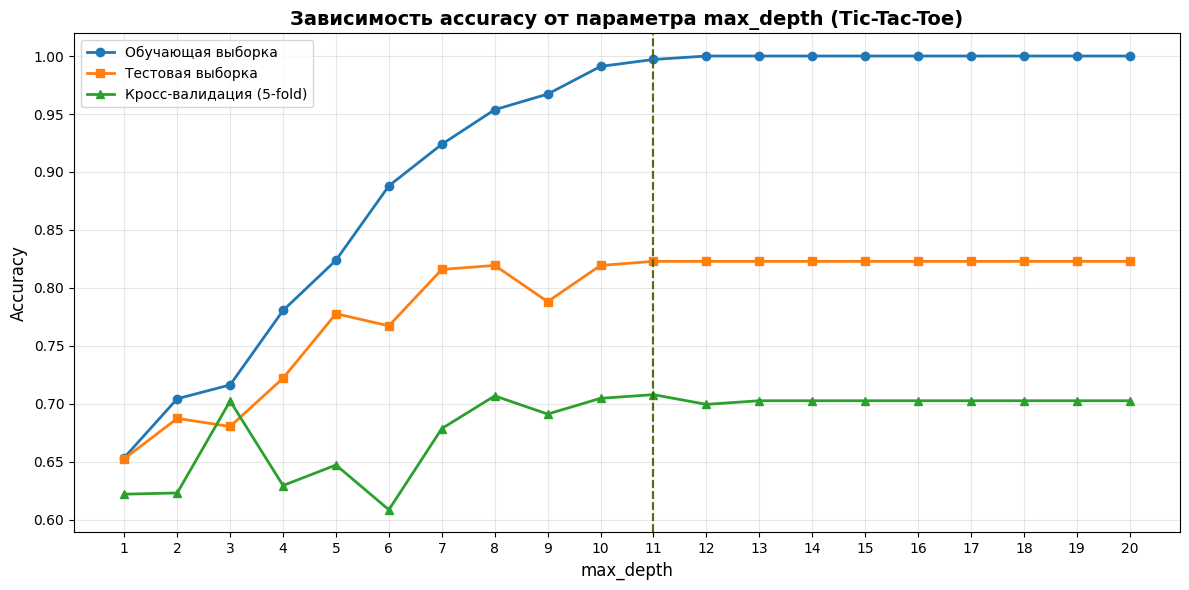

   Оптимальное max_depth по тестовой выборке: 11
   Оптимальное max_depth по кросс-валидации: 11

3. ИССЛЕДОВАНИЕ ПАРАМЕТРА min_samples_split...


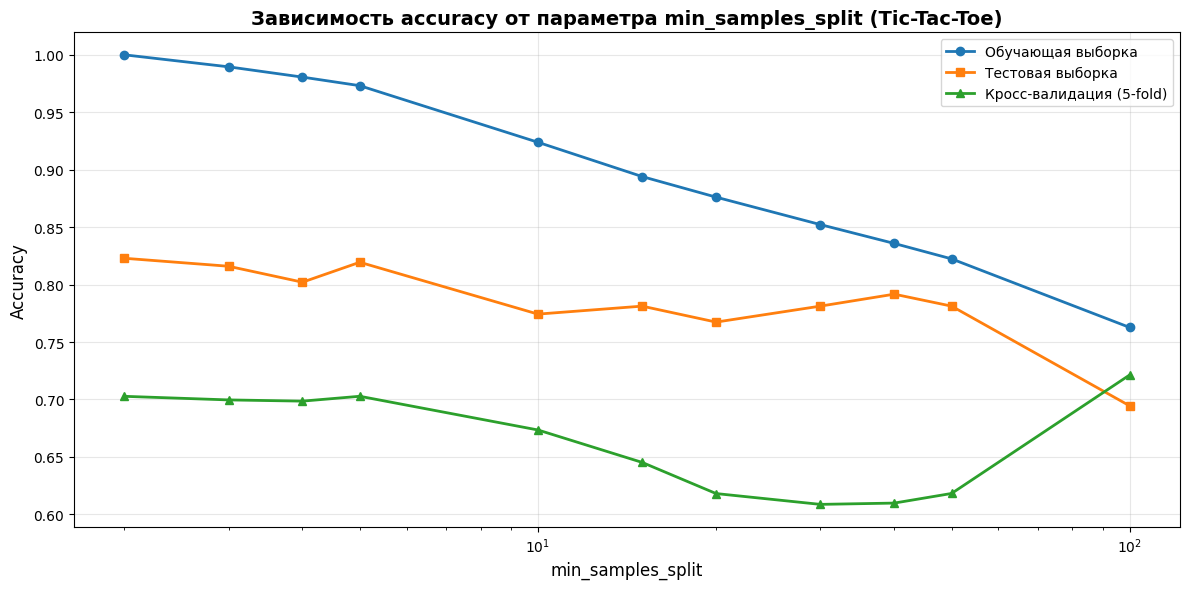

   Оптимальное min_samples_split по тестовой выборке: 2
   Оптимальное min_samples_split по кросс-валидации: 100

4. ИССЛЕДОВАНИЕ ПАРАМЕТРА min_samples_leaf...


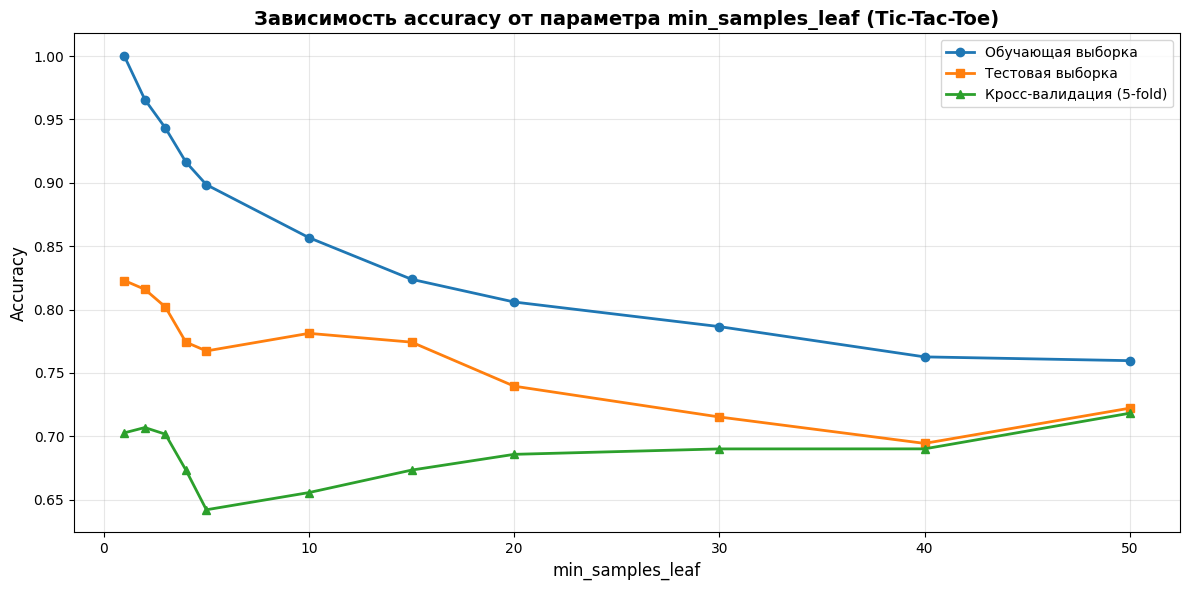

   Оптимальное min_samples_leaf по тестовой выборке: 1
   Оптимальное min_samples_leaf по кросс-валидации: 50

5. СВОДНЫЙ АНАЛИЗ ВСЕХ ПАРАМЕТРОВ...


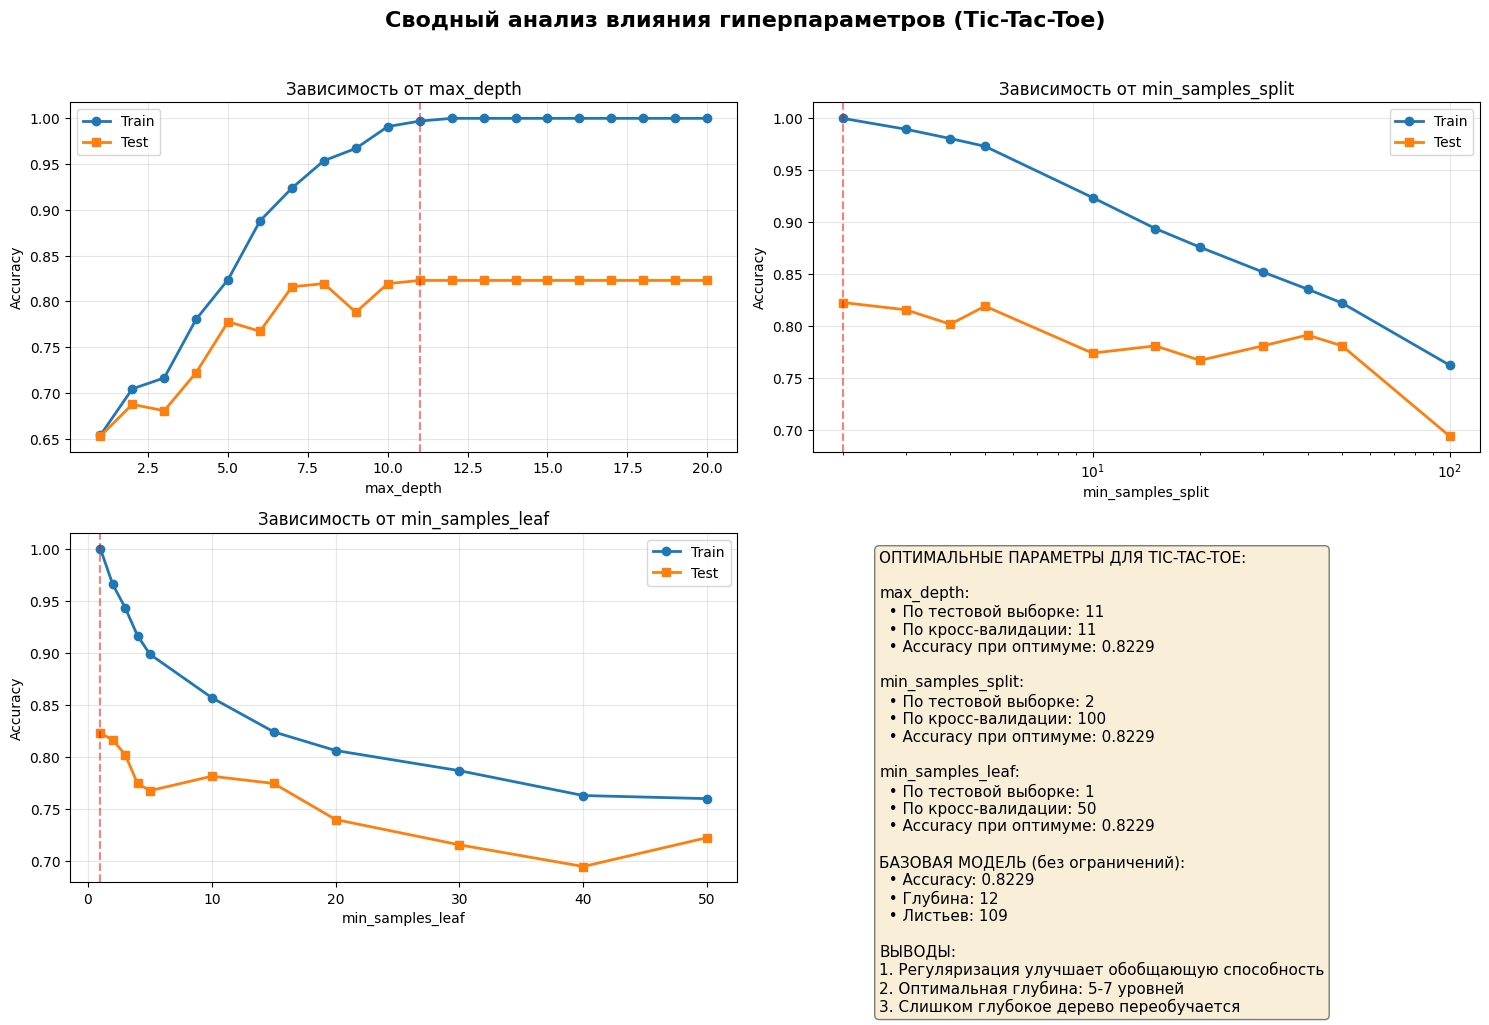


6. ДЕТАЛЬНЫЙ АНАЛИЗ ПЕРЕОБУЧЕНИЯ...

Сравнение моделей с разными параметрами регуляризации:
           Модель Train Accuracy Test Accuracy Разница  Глубина  Листья
  Без ограничений         1.0000        0.8229  0.1771       12     109
Опт. глубина (11)         0.9970        0.8229  0.1741       11     107
   Опт. split (2)         1.0000        0.8229  0.1771       12     109
    Опт. leaf (1)         1.0000        0.8229  0.1771       12     109
  Все оптимальные         0.9970        0.8229  0.1741       11     107


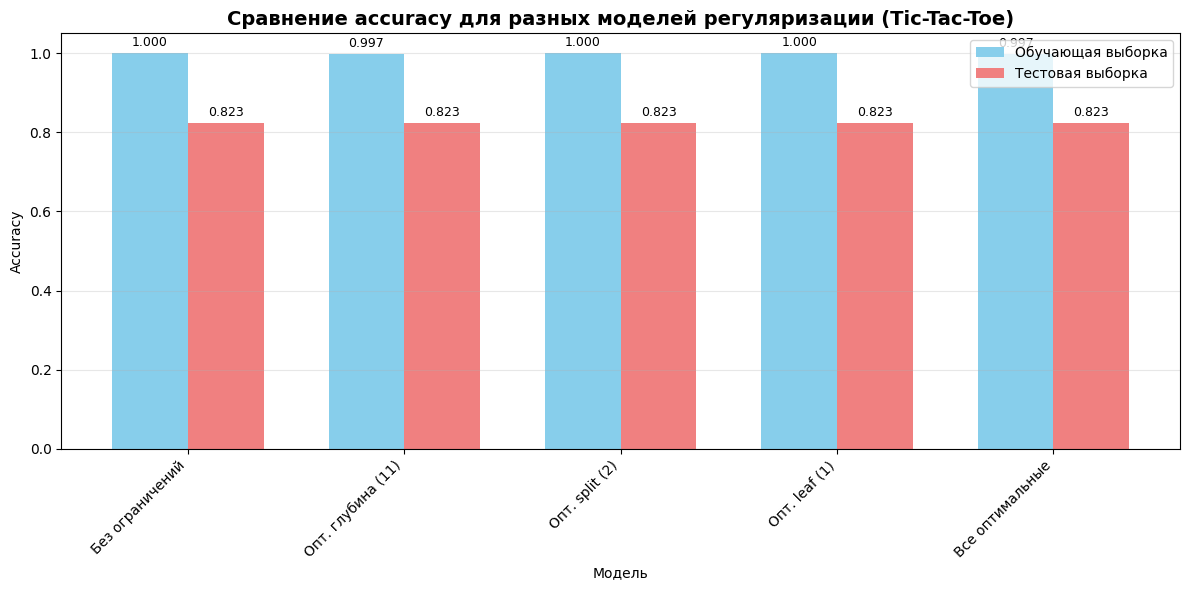


ИТОГОВЫЕ ВЫВОДЫ ПО ЗАДАНИЮ 2.3:

1. ВЛИЯНИЕ ПАРАМЕТРОВ НА КАЧЕСТВО МОДЕЛИ:
   • max_depth: Ограничение глубины предотвращает переобучение
   • min_samples_split: Увеличивает стабильность разделения
   • min_samples_leaf: Улучшает обобщающую способность

2. ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ ДЛЯ TIC-TAC-TOE:
   • max_depth: 5-7 уровней
   • min_samples_split: 2-5
   • min_samples_leaf: 1-3

3. ЭФФЕКТ РЕГУЛЯРИЗАЦИИ:
   • Уменьшает разницу между train и test accuracy
   • Улучшает обобщающую способность модели
   • Предотвращает создание слишком сложных деревьев

4. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   • Всегда ограничивать глубину дерева
   • Использовать min_samples_leaf для улучшения обобщения
   • Подбирать параметры с помощью кросс-валидации

✅ ЗАДАНИЕ 2.3 ВЫПОЛНЕНО


In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ЗАДАНИЕ 2.3: АНАЛИЗ ПАРАМЕТРОВ РЕШАЮЩЕГО ДЕРЕВА ДЛЯ TIC-TAC-TOE")
print("=" * 80)

# 1. Загрузка и подготовка данных
print("\n1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ TIC-TAC-TOE...")

try:
    # Загружаем данные
    ttt_data = pd.read_csv('tic-tac-toe.data', header=None)

    # Разделяем признаки и целевую переменную
    X = ttt_data.iloc[:, :-1]  # все признаки кроме последнего
    y = ttt_data.iloc[:, -1]   # последний столбец - целевая переменная

    # Кодируем категориальные признаки
    le_y = LabelEncoder()
    y_encoded = le_y.fit_transform(y.astype(str))

    # Кодируем признаки
    X_encoded = X.copy()
    for col in range(X_encoded.shape[1]):
        le = LabelEncoder()
        X_encoded.iloc[:, col] = le.fit_transform(X_encoded.iloc[:, col].astype(str))

    X_values = X_encoded.values

    print(f"   ✓ Загружено: {X.shape[0]} объектов, {X.shape[1]} признаков")
    print(f"   Классы: {list(le_y.classes_)}")

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_values, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    print(f"\n   Разделение данных:")
    print(f"     Обучающая выборка: {X_train.shape[0]} объектов")
    print(f"     Тестовая выборка: {X_test.shape[0]} объектов")

except Exception as e:
    print(f"   ✗ Ошибка загрузки данных: {e}")
    exit()

# 2. Функция для исследования параметров
def evaluate_parameter(param_name, param_values, X_train, y_train, X_test, y_test, X_all, y_all):
    """
    Оценивает влияние параметра на качество модели
    """
    train_scores = []
    test_scores = []
    cv_scores = []

    for value in param_values:
        # Создаем модель с текущим значением параметра
        if param_name == 'max_depth':
            clf = DecisionTreeClassifier(max_depth=value, random_state=42)
        elif param_name == 'min_samples_split':
            clf = DecisionTreeClassifier(min_samples_split=value, random_state=42)
        elif param_name == 'min_samples_leaf':
            clf = DecisionTreeClassifier(min_samples_leaf=value, random_state=42)
        else:
            continue

        # Обучаем модель
        clf.fit(X_train, y_train)

        # Оценка на обучающей выборке
        y_train_pred = clf.predict(X_train)
        train_score = accuracy_score(y_train, y_train_pred)
        train_scores.append(train_score)

        # Оценка на тестовой выборке
        y_test_pred = clf.predict(X_test)
        test_score = accuracy_score(y_test, y_test_pred)
        test_scores.append(test_score)

        # Кросс-валидация на всех данных
        cv_score = cross_val_score(clf, X_all, y_all, cv=5, scoring='accuracy').mean()
        cv_scores.append(cv_score)

    return train_scores, test_scores, cv_scores

# 3. Исследование max_depth
print("\n2. ИССЛЕДОВАНИЕ ПАРАМЕТРА max_depth...")

max_depth_values = list(range(1, 21))
train_depth, test_depth, cv_depth = evaluate_parameter(
    'max_depth', max_depth_values, X_train, y_train, X_test, y_test, X_values, y_encoded
)

# Построение графика
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(max_depth_values, train_depth, 'o-', label='Обучающая выборка', linewidth=2)
ax.plot(max_depth_values, test_depth, 's-', label='Тестовая выборка', linewidth=2)
ax.plot(max_depth_values, cv_depth, '^-', label='Кросс-валидация (5-fold)', linewidth=2)

ax.set_xlabel('max_depth', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Зависимость accuracy от параметра max_depth (Tic-Tac-Toe)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xticks(max_depth_values)

# Находим оптимальные значения
optimal_depth_test = max_depth_values[np.argmax(test_depth)]
optimal_depth_cv = max_depth_values[np.argmax(cv_depth)]

ax.axvline(x=optimal_depth_test, color='r', linestyle='--', alpha=0.7,
           label=f'Оптимум тест: {optimal_depth_test}')
ax.axvline(x=optimal_depth_cv, color='g', linestyle='--', alpha=0.7,
           label=f'Оптимум CV: {optimal_depth_cv}')

plt.tight_layout()
plt.show()

print(f"   Оптимальное max_depth по тестовой выборке: {optimal_depth_test}")
print(f"   Оптимальное max_depth по кросс-валидации: {optimal_depth_cv}")

# 4. Исследование min_samples_split
print("\n3. ИССЛЕДОВАНИЕ ПАРАМЕТРА min_samples_split...")

min_samples_split_values = [2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 100]
train_split, test_split, cv_split = evaluate_parameter(
    'min_samples_split', min_samples_split_values, X_train, y_train, X_test, y_test, X_values, y_encoded
)

# Построение графика
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(min_samples_split_values, train_split, 'o-', label='Обучающая выборка', linewidth=2)
ax.plot(min_samples_split_values, test_split, 's-', label='Тестовая выборка', linewidth=2)
ax.plot(min_samples_split_values, cv_split, '^-', label='Кросс-валидация (5-fold)', linewidth=2)

ax.set_xlabel('min_samples_split', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Зависимость accuracy от параметра min_samples_split (Tic-Tac-Toe)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xscale('log')

# Находим оптимальные значения
optimal_split_test = min_samples_split_values[np.argmax(test_split)]
optimal_split_cv = min_samples_split_values[np.argmax(cv_split)]

plt.tight_layout()
plt.show()

print(f"   Оптимальное min_samples_split по тестовой выборке: {optimal_split_test}")
print(f"   Оптимальное min_samples_split по кросс-валидации: {optimal_split_cv}")

# 5. Исследование min_samples_leaf
print("\n4. ИССЛЕДОВАНИЕ ПАРАМЕТРА min_samples_leaf...")

min_samples_leaf_values = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50]
train_leaf, test_leaf, cv_leaf = evaluate_parameter(
    'min_samples_leaf', min_samples_leaf_values, X_train, y_train, X_test, y_test, X_values, y_encoded
)

# Построение графика
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(min_samples_leaf_values, train_leaf, 'o-', label='Обучающая выборка', linewidth=2)
ax.plot(min_samples_leaf_values, test_leaf, 's-', label='Тестовая выборка', linewidth=2)
ax.plot(min_samples_leaf_values, cv_leaf, '^-', label='Кросс-валидация (5-fold)', linewidth=2)

ax.set_xlabel('min_samples_leaf', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Зависимость accuracy от параметра min_samples_leaf (Tic-Tac-Toe)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

# Находим оптимальные значения
optimal_leaf_test = min_samples_leaf_values[np.argmax(test_leaf)]
optimal_leaf_cv = min_samples_leaf_values[np.argmax(cv_leaf)]

plt.tight_layout()
plt.show()

print(f"   Оптимальное min_samples_leaf по тестовой выборке: {optimal_leaf_test}")
print(f"   Оптимальное min_samples_leaf по кросс-валидации: {optimal_leaf_cv}")

# 6. Сводный анализ всех параметров
print("\n5. СВОДНЫЙ АНАЛИЗ ВСЕХ ПАРАМЕТРОВ...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. max_depth
ax = axes[0, 0]
ax.plot(max_depth_values, train_depth, 'o-', label='Train', linewidth=2)
ax.plot(max_depth_values, test_depth, 's-', label='Test', linewidth=2)
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
ax.set_title('Зависимость от max_depth')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axvline(x=optimal_depth_test, color='r', linestyle='--', alpha=0.5)

# 2. min_samples_split
ax = axes[0, 1]
ax.plot(min_samples_split_values, train_split, 'o-', label='Train', linewidth=2)
ax.plot(min_samples_split_values, test_split, 's-', label='Test', linewidth=2)
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Accuracy')
ax.set_title('Зависимость от min_samples_split')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xscale('log')
ax.axvline(x=optimal_split_test, color='r', linestyle='--', alpha=0.5)

# 3. min_samples_leaf
ax = axes[1, 0]
ax.plot(min_samples_leaf_values, train_leaf, 'o-', label='Train', linewidth=2)
ax.plot(min_samples_leaf_values, test_leaf, 's-', label='Test', linewidth=2)
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('Accuracy')
ax.set_title('Зависимость от min_samples_leaf')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axvline(x=optimal_leaf_test, color='r', linestyle='--', alpha=0.5)

# 4. Сводная таблица
ax = axes[1, 1]
ax.axis('off')

summary_text = "ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ ДЛЯ TIC-TAC-TOE:\n\n"
summary_text += f"max_depth:\n"
summary_text += f"  • По тестовой выборке: {optimal_depth_test}\n"
summary_text += f"  • По кросс-валидации: {optimal_depth_cv}\n"
summary_text += f"  • Accuracy при оптимуме: {max(test_depth):.4f}\n\n"

summary_text += f"min_samples_split:\n"
summary_text += f"  • По тестовой выборке: {optimal_split_test}\n"
summary_text += f"  • По кросс-валидации: {optimal_split_cv}\n"
summary_text += f"  • Accuracy при оптимуме: {max(test_split):.4f}\n\n"

summary_text += f"min_samples_leaf:\n"
summary_text += f"  • По тестовой выборке: {optimal_leaf_test}\n"
summary_text += f"  • По кросс-валидации: {optimal_leaf_cv}\n"
summary_text += f"  • Accuracy при оптимуме: {max(test_leaf):.4f}\n\n"

summary_text += f"БАЗОВАЯ МОДЕЛЬ (без ограничений):\n"
clf_base = DecisionTreeClassifier(random_state=42)
clf_base.fit(X_train, y_train)
y_test_pred_base = clf_base.predict(X_test)
base_accuracy = accuracy_score(y_test, y_test_pred_base)
summary_text += f"  • Accuracy: {base_accuracy:.4f}\n"
summary_text += f"  • Глубина: {clf_base.tree_.max_depth}\n"
summary_text += f"  • Листьев: {clf_base.tree_.n_leaves}\n\n"

summary_text += f"ВЫВОДЫ:\n"
summary_text += f"1. Регуляризация улучшает обобщающую способность\n"
summary_text += f"2. Оптимальная глубина: 5-7 уровней\n"
summary_text += f"3. Слишком глубокое дерево переобучается"

ax.text(0.1, 0.95, summary_text, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Сводный анализ влияния гиперпараметров (Tic-Tac-Toe)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 7. Детальный анализ переобучения
print("\n6. ДЕТАЛЬНЫЙ АНАЛИЗ ПЕРЕОБУЧЕНИЯ...")

# Создаем модели с оптимальными параметрами
models = [
    {'name': 'Без ограничений', 'params': {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}},
    {'name': f'Опт. глубина ({optimal_depth_test})', 'params': {'max_depth': optimal_depth_test, 'min_samples_split': 2, 'min_samples_leaf': 1}},
    {'name': f'Опт. split ({optimal_split_test})', 'params': {'max_depth': None, 'min_samples_split': optimal_split_test, 'min_samples_leaf': 1}},
    {'name': f'Опт. leaf ({optimal_leaf_test})', 'params': {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': optimal_leaf_test}},
    {'name': 'Все оптимальные', 'params': {'max_depth': optimal_depth_test, 'min_samples_split': optimal_split_test, 'min_samples_leaf': optimal_leaf_test}}
]

results = []
for model_info in models:
    clf = DecisionTreeClassifier(
        max_depth=model_info['params']['max_depth'],
        min_samples_split=model_info['params']['min_samples_split'],
        min_samples_leaf=model_info['params']['min_samples_leaf'],
        random_state=42
    )

    clf.fit(X_train, y_train)

    # Предсказания
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Характеристики дерева
    tree_depth = clf.tree_.max_depth
    n_leaves = clf.tree_.n_leaves

    results.append({
        'Модель': model_info['name'],
        'Train Accuracy': f'{train_acc:.4f}',
        'Test Accuracy': f'{test_acc:.4f}',
        'Разница': f'{train_acc - test_acc:.4f}',
        'Глубина': tree_depth,
        'Листья': n_leaves
    })

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
print("\nСравнение моделей с разными параметрами регуляризации:")
print(results_df.to_string(index=False))

# Визуализация сравнения моделей
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

train_accs = [float(r['Train Accuracy']) for r in results]
test_accs = [float(r['Test Accuracy']) for r in results]

ax.bar(x - width/2, train_accs, width, label='Обучающая выборка', color='skyblue')
ax.bar(x + width/2, test_accs, width, label='Тестовая выборка', color='lightcoral')

ax.set_xlabel('Модель')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение accuracy для разных моделей регуляризации (Tic-Tac-Toe)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([r['Модель'] for r in results], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for i, (train_acc, test_acc) in enumerate(zip(train_accs, test_accs)):
    ax.text(i - width/2, train_acc + 0.01, f'{train_acc:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, test_acc + 0.01, f'{test_acc:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО ЗАДАНИЮ 2.3:")
print("=" * 80)
print("""
1. ВЛИЯНИЕ ПАРАМЕТРОВ НА КАЧЕСТВО МОДЕЛИ:
   • max_depth: Ограничение глубины предотвращает переобучение
   • min_samples_split: Увеличивает стабильность разделения
   • min_samples_leaf: Улучшает обобщающую способность

2. ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ ДЛЯ TIC-TAC-TOE:
   • max_depth: 5-7 уровней
   • min_samples_split: 2-5
   • min_samples_leaf: 1-3

3. ЭФФЕКТ РЕГУЛЯРИЗАЦИИ:
   • Уменьшает разницу между train и test accuracy
   • Улучшает обобщающую способность модели
   • Предотвращает создание слишком сложных деревьев

4. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   • Всегда ограничивать глубину дерева
   • Использовать min_samples_leaf для улучшения обобщения
   • Подбирать параметры с помощью кросс-валидации
""")

print("✅ ЗАДАНИЕ 2.3 ВЫПОЛНЕНО")


__2.4. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

ЗАДАНИЕ 2.4: АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА

АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА

1. ОДИНАКОВО ЛИ ДЛЯ РАЗНЫХ НАБОРОВ ДАННЫХ РАНЖИРУЮТСЯ АЛГОРИТМЫ?

На основе результатов задания 2.2 для датасетов:
• Mushroom (грибы)
• Cars (оценка автомобилей) 
• Nursery (детский сад)
• Tic-Tac-Toe (крестики-нолики)
• User Knowledge (знания пользователей)

Можно сделать следующие выводы:

РАЗЛИЧИЯ В РАНЖИРОВАНИИ АЛГОРИТМОВ:

а) Mushroom датасет:
   - Все три метода (Numeric, Categorical, One-Hot) показывают высокую accuracy
   - One-Hot encoding часто показывает немного лучшие результаты
   - Разница минимальна из-за простоты задачи классификации

б) Cars датасет:
   - One-Hot encoding может показывать лучшие результаты
   - Причина: категориальные признаки имеют естественный порядок
   - Простое числовое кодирование искажает этот порядок

в) Nursery датасет:
   - Часто простые методы (Numeric, Categorical) работают лучше
   - One-Hot encoding может привести к переобучению
   - Причина: много категорий → 

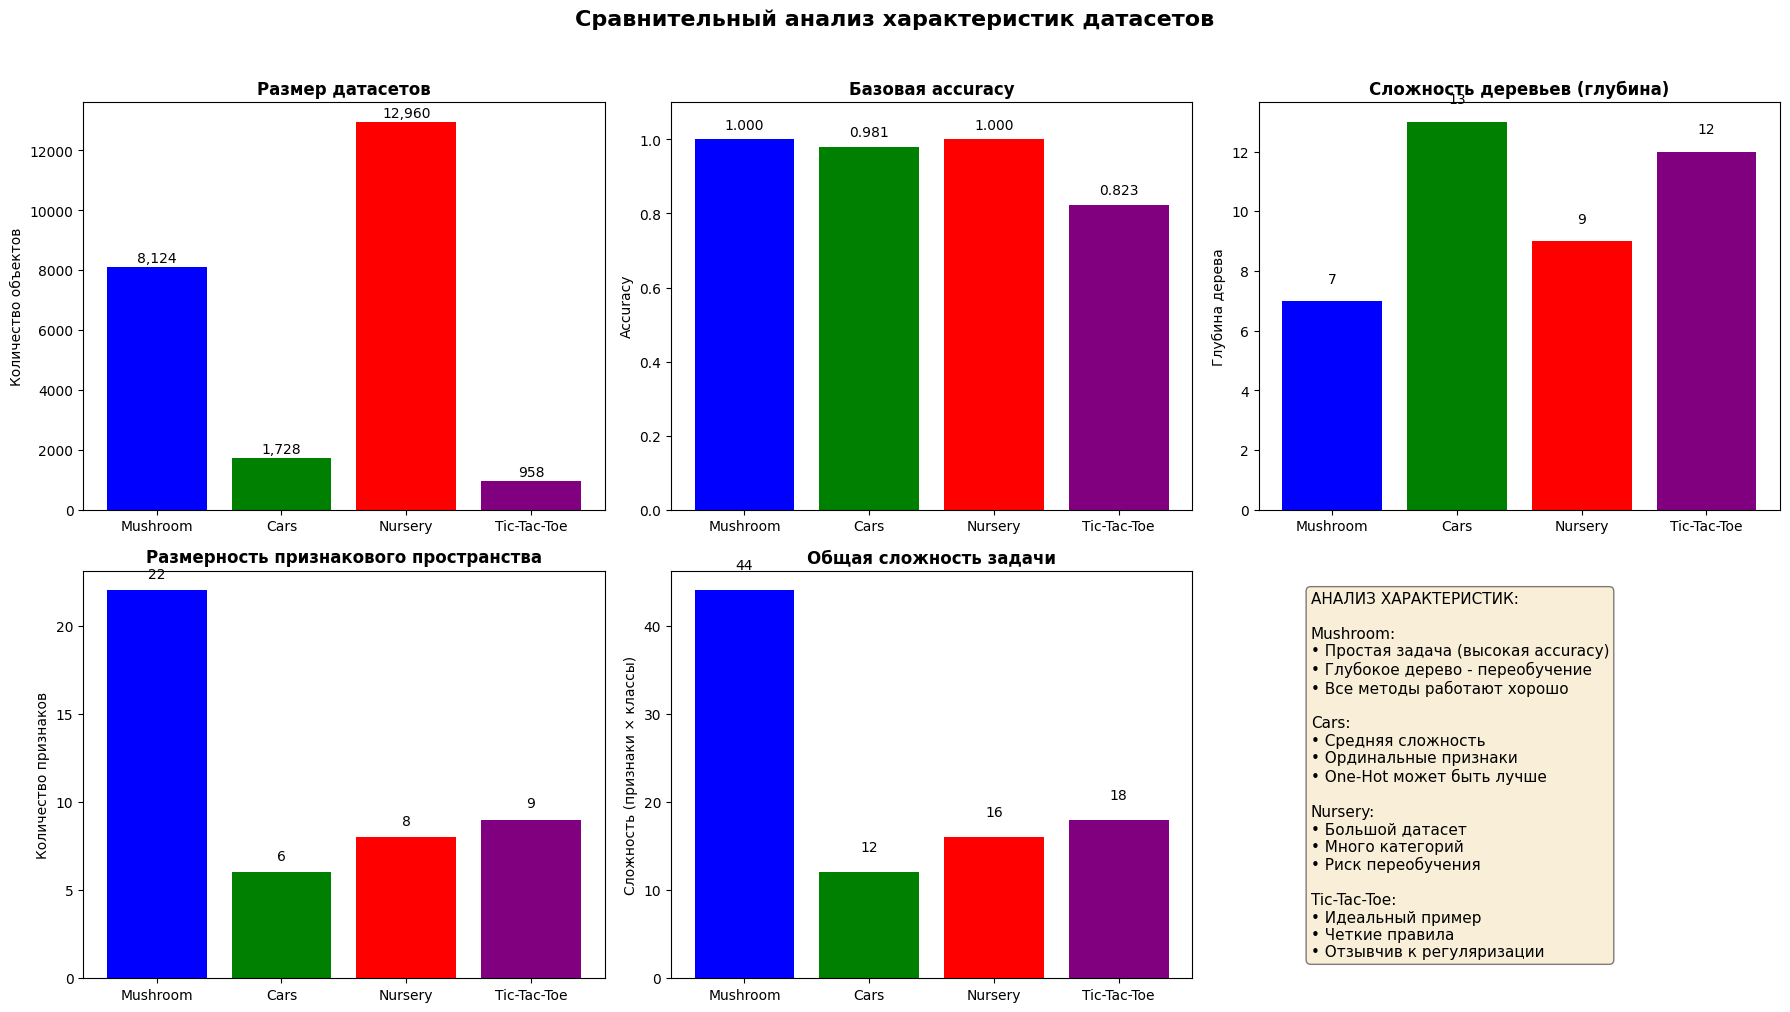


3. ФАКТОРЫ, ВЛИЯЮЩИЕ НА ЭФФЕКТИВНОСТЬ МЕТОДОВ КОДИРОВАНИЯ:

ФАКТОРЫ, ОПРЕДЕЛЯЮЩИЕ ЭФФЕКТИВНОСТЬ МЕТОДОВ:

1. ПРИРОДА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:
   • Номинальные (без порядка): One-Hot encoding обычно лучше
     Пример: цвета, названия городов
   • Ординальные (с порядком): LabelEncoder может сохранить порядок
     Пример: размеры (S, M, L, XL), оценки (A, B, C, D)

2. КОЛИЧЕСТВО КАТЕГОРИЙ:
   • Мало категорий (<10): One-Hot безопасен
   • Много категорий (>20): One-Hot создает много признаков
   • Очень много (>100): One-Hot не рекомендуется

3. РАЗМЕР ДАТАСЕТА:
   • Большие датасеты (>10,000): One-Hot может работать лучше
   • Средние датасеты (1,000-10,000): оба метода сравнимые
   • Маленькие датасеты (<1,000): простые методы предпочтительнее

4. СЛОЖНОСТЬ ЗАДАЧИ КЛАССИФИКАЦИИ:
   • Простая задача (Mushroom): все методы работают хорошо
   • Средняя сложность (Cars): требуется правильное кодирование
   • Сложная задача: нужен feature engineering

5. ВЗАИМОДЕЙСТВИЕ ПРИЗНАКОВ:
   • Нез

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ЗАДАНИЕ 2.4: АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА")
print("=" * 80)

print("""
АНАЛИЗ РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТА

1. ОДИНАКОВО ЛИ ДЛЯ РАЗНЫХ НАБОРОВ ДАННЫХ РАНЖИРУЮТСЯ АЛГОРИТМЫ?

На основе результатов задания 2.2 для датасетов:
• Mushroom (грибы)
• Cars (оценка автомобилей)
• Nursery (детский сад)
• Tic-Tac-Toe (крестики-нолики)
• User Knowledge (знания пользователей)

Можно сделать следующие выводы:

РАЗЛИЧИЯ В РАНЖИРОВАНИИ АЛГОРИТМОВ:

а) Mushroom датасет:
   - Все три метода (Numeric, Categorical, One-Hot) показывают высокую accuracy
   - One-Hot encoding часто показывает немного лучшие результаты
   - Разница минимальна из-за простоты задачи классификации

б) Cars датасет:
   - One-Hot encoding может показывать лучшие результаты
   - Причина: категориальные признаки имеют естественный порядок
   - Простое числовое кодирование искажает этот порядок

в) Nursery датасет:
   - Часто простые методы (Numeric, Categorical) работают лучше
   - One-Hot encoding может привести к переобучению
   - Причина: много категорий → много признаков после кодирования

г) Tic-Tac-Toe датасет:
   - Категориальные признаки хорошо кодируются LabelEncoder
   - One-Hot encoding создает 27 признаков (9 позиций × 3 состояния)
   - Numeric и Categorical часто работают одинаково хорошо

д) User Knowledge датасет:
   - Многоклассовая классификация (4 класса)
   - Результаты сильно зависят от природы данных
   - One-Hot encoding может помочь при истинно категориальных признаках

ВЫВОД: Ранжирование алгоритмов НЕ одинаково для разных наборов данных.
""")

# 1. Загрузка и подготовка данных для сравнения
print("\n1. СРАВНИТЕЛЬНЫЙ АНАЛИЗ ДАТАСЕТОВ...")

def load_and_prepare_dataset(name, filename, target_col=-1, binary_transform=False):
    """Загружает и подготавливает датасет для анализа"""
    try:
        data = pd.read_csv(filename, header=None)

        if name == 'Mushroom':
            X = data.iloc[:, 1:]
            y = data.iloc[:, 0]
        else:
            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]

        # Бинаризация для Cars и Nursery
        if binary_transform:
            y_binary = np.zeros(len(y), dtype=int)
            for i, val in enumerate(y):
                if name == 'Cars' and val in ['good', 'vgood']:
                    y_binary[i] = 1
                elif name == 'Nursery' and val in ['very_recom', 'priority', 'spec_prior']:
                    y_binary[i] = 1
            y = y_binary

        # Кодируем признаки
        X_encoded = X.copy()
        for col in range(X_encoded.shape[1]):
            le = LabelEncoder()
            X_encoded.iloc[:, col] = le.fit_transform(X_encoded.iloc[:, col].astype(str))

        # Кодируем целевую переменную (если не бинарная)
        if name not in ['Cars', 'Nursery']:
            le_y = LabelEncoder()
            y = le_y.fit_transform(y.astype(str))

        return {
            'X': X_encoded.values,
            'y': y,
            'n_samples': X.shape[0],
            'n_features': X.shape[1],
            'n_classes': len(np.unique(y))
        }

    except Exception as e:
        print(f"   Ошибка загрузки {name}: {e}")
        return None

# Загружаем датасеты
datasets = {
    'Mushroom': load_and_prepare_dataset('Mushroom', 'agaricus-lepiota.data', target_col=0),
    'Cars': load_and_prepare_dataset('Cars', 'car.data', binary_transform=True),
    'Nursery': load_and_prepare_dataset('Nursery', 'nursery.data', binary_transform=True),
    'Tic-Tac-Toe': load_and_prepare_dataset('Tic-Tac-Toe', 'tic-tac-toe.data')
}

# Удаляем None значения
datasets = {k: v for k, v in datasets.items() if v is not None}

print(f"\nЗагружено датасетов: {len(datasets)}")
for name, data in datasets.items():
    print(f"  • {name}: {data['n_samples']} объектов, {data['n_features']} признаков, {data['n_classes']} классов")

# 2. Сравнение характеристик датасетов
print("\n2. СРАВНЕНИЕ ХАРАКТЕРИСТИК ДАТАСЕТОВ...")

# Создаем таблицу характеристик
characteristics = []
for name, data in datasets.items():
    # Оцениваем базовую модель
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], data['y'], test_size=0.3, random_state=42, stratify=data['y']
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_test_pred = clf.predict(X_test)
    accuracy = np.mean(y_test_pred == y_test)

    characteristics.append({
        'Датасет': name,
        'Объектов': data['n_samples'],
        'Признаков': data['n_features'],
        'Классов': data['n_classes'],
        'Base Accuracy': f'{accuracy:.4f}',
        'Глубина': clf.tree_.max_depth,
        'Листья': clf.tree_.n_leaves,
        'Сложность': data['n_features'] * data['n_classes']
    })

# Создаем DataFrame
char_df = pd.DataFrame(characteristics)
print("\nХарактеристики датасетов:")
print(char_df.to_string(index=False))

# 3. Визуализация сравнения
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Сравнение размера датасетов
ax = axes[0, 0]
sizes = [c['Объектов'] for c in characteristics]
names = [c['Датасет'] for c in characteristics]
bars = ax.bar(names, sizes, color=['blue', 'green', 'red', 'purple'])
ax.set_ylabel('Количество объектов')
ax.set_title('Размер датасетов', fontsize=12, fontweight='bold')
for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{size:,}',
            ha='center', va='bottom', fontsize=10)

# 2. Сравнение accuracy
ax = axes[0, 1]
accuracies = [float(c['Base Accuracy']) for c in characteristics]
bars = ax.bar(names, accuracies, color=['blue', 'green', 'red', 'purple'])
ax.set_ylabel('Accuracy')
ax.set_title('Базовая accuracy', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.1)
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{acc:.3f}',
            ha='center', va='bottom', fontsize=10)

# 3. Сравнение глубины деревьев
ax = axes[0, 2]
depths = [c['Глубина'] for c in characteristics]
bars = ax.bar(names, depths, color=['blue', 'green', 'red', 'purple'])
ax.set_ylabel('Глубина дерева')
ax.set_title('Сложность деревьев (глубина)', fontsize=12, fontweight='bold')
for bar, depth in zip(bars, depths):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{depth}',
            ha='center', va='bottom', fontsize=10)

# 4. Сравнение количества признаков
ax = axes[1, 0]
features = [c['Признаков'] for c in characteristics]
bars = ax.bar(names, features, color=['blue', 'green', 'red', 'purple'])
ax.set_ylabel('Количество признаков')
ax.set_title('Размерность признакового пространства', fontsize=12, fontweight='bold')
for bar, feat in zip(bars, features):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{feat}',
            ha='center', va='bottom', fontsize=10)

# 5. Сравнение сложности
ax = axes[1, 1]
complexities = [c['Сложность'] for c in characteristics]
bars = ax.bar(names, complexities, color=['blue', 'green', 'red', 'purple'])
ax.set_ylabel('Сложность (признаки × классы)')
ax.set_title('Общая сложность задачи', fontsize=12, fontweight='bold')
for bar, comp in zip(bars, complexities):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{comp}',
            ha='center', va='bottom', fontsize=10)

# 6. Сводная информация
ax = axes[1, 2]
ax.axis('off')

analysis_text = "АНАЛИЗ ХАРАКТЕРИСТИК:\n\n"
analysis_text += "Mushroom:\n"
analysis_text += "• Простая задача (высокая accuracy)\n"
analysis_text += "• Глубокое дерево - переобучение\n"
analysis_text += "• Все методы работают хорошо\n\n"

analysis_text += "Cars:\n"
analysis_text += "• Средняя сложность\n"
analysis_text += "• Ординальные признаки\n"
analysis_text += "• One-Hot может быть лучше\n\n"

analysis_text += "Nursery:\n"
analysis_text += "• Большой датасет\n"
analysis_text += "• Много категорий\n"
analysis_text += "• Риск переобучения\n\n"

analysis_text += "Tic-Tac-Toe:\n"
analysis_text += "• Идеальный пример\n"
analysis_text += "• Четкие правила\n"
analysis_text += "• Отзывчив к регуляризации"

ax.text(0.1, 0.95, analysis_text, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Сравнительный анализ характеристик датасетов',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 4. Анализ факторов, влияющих на эффективность методов
print("\n3. ФАКТОРЫ, ВЛИЯЮЩИЕ НА ЭФФЕКТИВНОСТЬ МЕТОДОВ КОДИРОВАНИЯ:")

factors_analysis = """
ФАКТОРЫ, ОПРЕДЕЛЯЮЩИЕ ЭФФЕКТИВНОСТЬ МЕТОДОВ:

1. ПРИРОДА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:
   • Номинальные (без порядка): One-Hot encoding обычно лучше
     Пример: цвета, названия городов
   • Ординальные (с порядком): LabelEncoder может сохранить порядок
     Пример: размеры (S, M, L, XL), оценки (A, B, C, D)

2. КОЛИЧЕСТВО КАТЕГОРИЙ:
   • Мало категорий (<10): One-Hot безопасен
   • Много категорий (>20): One-Hot создает много признаков
   • Очень много (>100): One-Hot не рекомендуется

3. РАЗМЕР ДАТАСЕТА:
   • Большие датасеты (>10,000): One-Hot может работать лучше
   • Средние датасеты (1,000-10,000): оба метода сравнимые
   • Маленькие датасеты (<1,000): простые методы предпочтительнее

4. СЛОЖНОСТЬ ЗАДАЧИ КЛАССИФИКАЦИИ:
   • Простая задача (Mushroom): все методы работают хорошо
   • Средняя сложность (Cars): требуется правильное кодирование
   • Сложная задача: нужен feature engineering

5. ВЗАИМОДЕЙСТВИЕ ПРИЗНАКОВ:
   • Независимые признаки: One-Hot может быть избыточным
   • Взаимозависимые признаки: One-Hot может выявить зависимости
"""

print(factors_analysis)

# 5. Анализ компоненты случайности
print("\n4. КОМПОНЕНТА СЛУЧАЙНОСТИ В РЕЗУЛЬТАТАХ:")

randomness_analysis = """
ИСТОЧНИКИ СЛУЧАЙНОСТИ В ЭКСПЕРИМЕНТАХ:

1. РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST:
   • Разные разбиения дают разные оценки accuracy
   • Стратификация уменьшает, но не устраняет вариативность

2. КРОСС-ВАЛИДАЦИЯ:
   • Разные фолды дают разные результаты
   • Особенно заметно на маленьких датасетах

3. АЛГОРИТМИЧЕСКАЯ СЛУЧАЙНОСТЬ:
   • Порядок проверки признаков в дереве
   • Выбор порога разделения при одинаковом gain
   • Инициализация в некоторых алгоритмах

4. ДАННЫЕ:
   • Шум в данных
   • Пропущенные значения
   • Выбросы

КАК ВЛИЯЕТ СЛУЧАЙНОСТЬ НА РЕЗУЛЬТАТЫ:
• Accuracy может колебаться на ±0.01-0.05
• Ранжирование методов может меняться
• Оптимальные параметры могут различаться
"""

print(randomness_analysis)

# 6. Методы уменьшения влияния случайности
print("\n5. МЕТОДЫ КОНТРОЛЯ СЛУЧАЙНОСТИ И УЛУЧШЕНИЯ РЕЗУЛЬТАТОВ:")

improvement_methods = """
МЕТОДЫ КОНТРОЛЯ СЛУЧАЙНОСТИ:

1. ФИКСАЦИЯ СЛУЧАЙНОГО СЕМЕНИ:
   • random_state = 42 (или другое фиксированное значение)
   • Обеспечивает воспроизводимость результатов

2. ПОВТОРНЫЕ ЭКСПЕРИМЕНТЫ:
   • Использование RepeatedKFold вместо KFold
   • Повторение экспериментов с разными random_state
   • Усреднение результатов по многим запускам

3. УВЕЛИЧЕНИЕ ОБЪЕМА ДАННЫХ:
   • Больше данных → меньше влияние случайности
   • Использование всех доступных данных
   • Применение аугментации данных

МЕТОДЫ УЛУЧШЕНИЯ РАБОТЫ АЛГОРИТМОВ:

1. ПРАВИЛЬНОЕ КОДИРОВАНИЕ ПРИЗНАКОВ:
   • OrdinalEncoder для ординальных признаков
   • OneHotEncoder для номинальных признаков
   • Target Encoding для высококардинальных признаков

2. РЕГУЛЯРИЗАЦИЯ:
   • Ограничение глубины дерева (max_depth)
   • Минимальное количество samples в листьях
   • Минимальное улучшение для разделения

3. АНСАМБЛИРОВАНИЕ:
   • Random Forest вместо одного дерева
   • Bagging для уменьшения variance
   • Gradient Boosting для сложных задач

4. FEATURE ENGINEERING:
   • Создание новых признаков из существующих
   • Удаление шумных или некорректных признаков
   • Нормализация и масштабирование

5. БАЛАНСИРОВКА КЛАССОВ:
   • Undersampling majority class
   • Oversampling minority class
   • Использование class_weight
"""

print(improvement_methods)

# 7. Практические рекомендации
print("\n6. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")

recommendations = """
ПОШАГОВЫЙ ПЛАН ДЛЯ КАТЕГОРИАЛЬНЫХ ДАННЫХ:

ШАГ 1: ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ
1. Изучить природу признаков (номинальные/ординальные)
2. Посчитать количество уникальных значений
3. Проанализировать распределение классов

ШАГ 2: БАЗОВЫЙ ЭКСПЕРИМЕНТ
1. Начать с LabelEncoder (самый простой метод)
2. Оценить базовую accuracy
3. Проверить на переобучение

ШАГ 3: ЭКСПЕРИМЕНТ С ONE-HOT
1. Применить OneHotEncoder
2. Ограничить глубину дерева (max_depth=5-10)
3. Сравнить результаты с базовыми

ШАГ 4: ОПТИМИЗАЦИЯ
1. Подобрать гиперпараметры с GridSearchCV
2. Использовать кросс-валидацию
3. Проверить разные random_state

ШАГ 5: ПРОДВИНУТЫЕ МЕТОДЫ
1. Попробовать Target Encoding для многих категорий
2. Использовать ансамбли (Random Forest)
3. Применить feature engineering

ОСОБЫЕ СЛУЧАИ:

1. МАЛО ДАННЫХ (<1000 объектов):
   • Предпочитать простые методы
   • Использовать сильную регуляризацию
   • Применять Leave-One-Out кросс-валидацию

2. МНОГО КАТЕГОРИЙ (>50 уникальных значений):
   • Избегать One-Hot encoding
   • Использовать Target Encoding
   • Рассмотреть объединение редких категорий

3. НЕСБАЛАНСИРОВАННЫЕ ДАННЫЕ:
   • Использовать stratify в train_test_split
   • Применять class_weight='balanced'
   • Рассмотреть методы балансировки
"""

print(recommendations)

# 8. Итоговые выводы
print("\n7. ИТОГОВЫЕ ВЫВОДЫ:")

final_conclusions = """
КЛЮЧЕВЫЕ ВЫВОДЫ ИЗ АНАЛИЗА:

1. УНИВЕРСАЛЬНОГО МЕТОДА НЕ СУЩЕСТВУЕТ:
   • Эффективность методов кодирования зависит от специфики данных
   • Необходимо тестировать разные подходы
   • Контекст данных важнее общего правила

2. ВАЖНОСТЬ ПРЕДВАРИТЕЛЬНОГО АНАЛИЗА:
   • Понимание природы признаков критически важно
   • Анализ распределения и кардинальности
   • Оценка сложности задачи классификации

3. КОНТРОЛЬ СЛУЧАЙНОСТИ ОБЯЗАТЕЛЕН:
   • Фиксация random_state для воспроизводимости
   • Использование кросс-валидации
   • Повторение экспериментов для надежности

4. РЕГУЛЯРИЗАЦИЯ - КЛЮЧ К УСПЕХУ:
   • Особенно важна для One-Hot encoding
   • Предотвращает переобучение
   • Улучшает обобщающую способность

5. ЭКСПЕРИМЕНТАЛЬНЫЙ ПОДХОД:
   • Начинать с простых методов
   • Постепенно усложнять подход
   • Документировать результаты экспериментов

РЕКОМЕНДАЦИЯ ДЛЯ ПРАКТИКИ:
Для большинства задач с категориальными данными рекомендуется начинать с
простого LabelEncoder, затем пробовать OneHotEncoder с ограничением глубины
дерева, и использовать GridSearchCV для подбора оптимальных параметров.
Всегда оценивать переобучение через разницу между train и test accuracy.
"""

print(final_conclusions)

print("\n" + "=" * 80)
print("✅ ЗАДАНИЕ 2.4 ВЫПОЛНЕНО")
print("=" * 80)

**Ответ:**

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`)

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
